In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from galaxy2galaxy import problems
import tensorflow as tf
from scipy.ndimage import convolve
import pickle
from itertools import chain

tf.enable_eager_execution()

%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

tf.version.VERSION

'1.15.0'

In [2]:
import sys
path = '/local/home/ua264756/GitHub/ADMM/'
sys.path.insert(1, path)

import plot_utils
from helper_func import *

data_path = '/local/home/ua264756/Data/'

In [3]:
tf.executing_eagerly()

True

### Loading Galaxy Images & PSF

In [4]:
# Open Batch
f = open(data_path + "meerkat_batch_2000.pkl", "rb")
batch = pickle.load(f)
f.close()

### Load Trained U-Net Model

In [5]:
model_1 = tf.keras.models.load_model(path + 'UNet_Denoiser/Models/UNet_radio_F{3600}_ep{20}spe{6250}nb{32}_WGN_fact{100}_SNR{1-50}', compile=False)

# ADMM in TensorFlow

In [6]:
# Projection - Enforce non-negative values
def proj(xi):
    
    return tf.cast(tf.math.maximum(xi, 0.0), tf.float32)

 
# H operator
def H(data, psf):
    
    return fftconvolve(data, psf)


# H transpose operator
def Ht(data, psf):
    
    return fftconvolve(data, tf.reverse(tf.reverse(psf, axis=[0]), axis=[1]))      # rotate by 180


# The gradient
def grad(y, x_rec, psf):

    return Ht(H(x_rec, psf) - y, psf)


# The cost function
def cost_func(y, x_rec, z, mu, rho, psf, var):

    temp = z - x_rec
    shape = mu.get_shape().as_list()
    
    cost_val = ( tf.cast(0.5, tf.float32) * rho * tf.norm(temp)**2  -
                 tf.matmul(tf.reshape(mu, [1, shape[0]*shape[1]]), tf.reshape(temp, [shape[0]*shape[1], 1]))  +
                 (tf.cast(0.5, tf.float32) / var) * tf.norm(y - H(x_rec, psf))**2 )
     
    return tf.keras.backend.eval(cost_val).flatten()


# Spectral value
def max_sv(psf, sigma, rho):
    
    H = tf.signal.fft2d(tf.cast(psf, tf.complex64))
    normH = tf.math.abs(tf.reverse(tf.reverse(H, axis=[0]), axis=[1]) * H  +  tf.cast(rho*sigma**2, tf.complex64))
    return tf.cast(tf.math.reduce_max(normH), tf.float32)
     
    
# Compute gradient step size   
def get_alpha(rho, sv, sigma):

    return (tf.cast(1.0, tf.float32) / 
            ((sv/(sigma**2) + rho) * tf.cast(1.0 + 1.0e-5, tf.float32)))


# Run ADMM
def runADMM(y, x_0, psf, grad, z_0, mu_0, rho_0, rho_max, eta, gamma, sigma_noise, n_iter, model):   
    
    # Convert arrays to tensors
    
    x_0 = tf.cast(x_0, tf.float32)
    z_0 = tf.cast(z_0, tf.float32)
    mu_0 = tf.cast(mu_0, tf.float32)
    rho_0 = tf.cast(rho_0, tf.float32)          # Augmented lagrangian hyperparameter
    rho_max = tf.cast(rho_max, tf.float32)      # max rho value
    eta = tf.cast(eta, tf.float32)              # should be between - [0, 1)
    gamma = tf.cast(gamma, tf.float32)          # multiplicative rho factor -- Should be > 1   
    
    # declare variables
    
    cost = np.full(n_iter, np.inf)
    nmse_arr = np.full(n_iter, np.inf)
    
    # ADMM parameters
    
    x_k = x_0
    z_k = z_0
    mu_k = mu_0
    rho_k = rho_0                                  # Augmented lagrangian hyperparameter
    delta_k = tf.cast(0.0, tf.float32)      

    # FISTA parameters
    
    t_k = tf.cast(1.0, tf.float32)
    z_fista_old = z_0
    sigma = tf.cast(sigma_noise, tf.float32)
      
    # square of spectral radius of convolution matrix
    
    sv = max_sv(psf, sigma, rho_k)           

    # The gradient descent step
    
    alpha = get_alpha(rho_k, sv, sigma) 
    
    # ADMM Loop 
    
    for k in range(n_iter): 
        
        ## FISTA update
        
        x_k1 = z_fista_old - alpha * (grad(y, z_fista_old, psf)  + 
                                      mu_k * sigma**2  + 
                                      rho_k * sigma**2 * (z_fista_old - z_k)) 
        
        x_k1 = proj(x_k1)             
        
        t_k1 = ( (tf.cast(1.0, tf.float32) + tf.math.sqrt(tf.cast(4.0, tf.float32)*t_k**2 + tf.cast(1.0, tf.float32))) 
                / tf.cast(2.0, tf.float32) )
        
        lambda_fista = tf.cast(1.0, tf.float32) + (t_k -  tf.cast(1.0, tf.float32)) / t_k1
        
        z_fista_new = x_k + lambda_fista * (x_k1 - x_k)
        
        z_fista_old = z_fista_new
        t_k = t_k1               
    
        ## Denoising sub-step
     
        z_k1 = x_k1 + (mu_k / rho_k)

        # U-Net Denoising
        
        fact = 1.0  #alpha * tf.norm(psf)
        z_k1 = tf.expand_dims(tf.expand_dims(z_k1, axis=0), axis=-1)
        z_k1 = tf.cast(tf.squeeze(model(z_k1 / fact)), tf.float32) * fact
        
        ## mu update
        
        mu_k1 = mu_k + (x_k1 - z_k1) * rho_k
               
        ## Cost
        
        cost[k] = cost_func(y, x_k1, z_k1, mu_k1, rho_k, psf, var=sigma**2)          
        
        ## Rho & alpha update       

        test1 = (tf.math.abs(gamma * rho_k) < tf.math.abs(rho_max))

        delta_k1 = tf.cond(test1, lambda: (tf.cast(1.0/gal_input.get_shape().as_list()[0], tf.float32) * 
                                           (tf.norm(x_k1 - x_k) + tf.norm(z_k1 - z_k) + tf.norm(mu_k1 - mu_k))), 
                                  lambda: delta_k)
                
        test2 = (test1 and (tf.math.abs(delta_k1) > tf.math.abs(eta * delta_k)))
        
        rho_k1 = tf.cond(test2, lambda: gamma * rho_k, lambda: rho_k)
        alpha = tf.cond(test2, lambda: get_alpha(rho_k1, sv, 1.0), lambda: alpha)            
        
        # Update all variables
        
        delta_k = tf.cond(test1, lambda: delta_k1, lambda: delta_k)
        rho_k = rho_k1
        x_k = x_k1
        mu_k = mu_k1
        z_k = z_k1
        sv = max_sv(psf, sigma, rho_k)       
               
        # Compute NMSE
        
        nmse_arr[k] = nmse(gal_target, x_k) 
        
        # Stopping Criteria
        
        if (np.abs(nmse_arr[k]-nmse_arr[k-1]) < 1e-4) or (np.abs(cost[k]-cost[k-1]) < 1e-4):
            return x_k, cost, nmse_arr   
          
        
    return x_k, cost, nmse_arr

### Run ADMM



 Galaxy Index = 1600



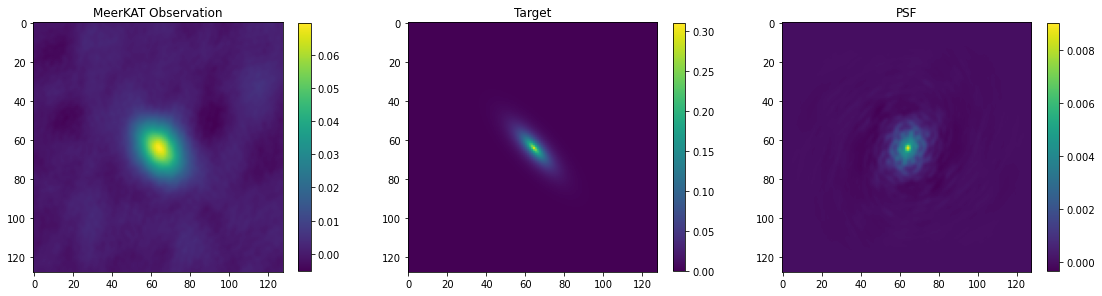

SNR (in Direct Space) = 42.34214660919456
Noise Std (in Direct Space) = 0.0016424262577900662
PSF Flux =  0.9999999



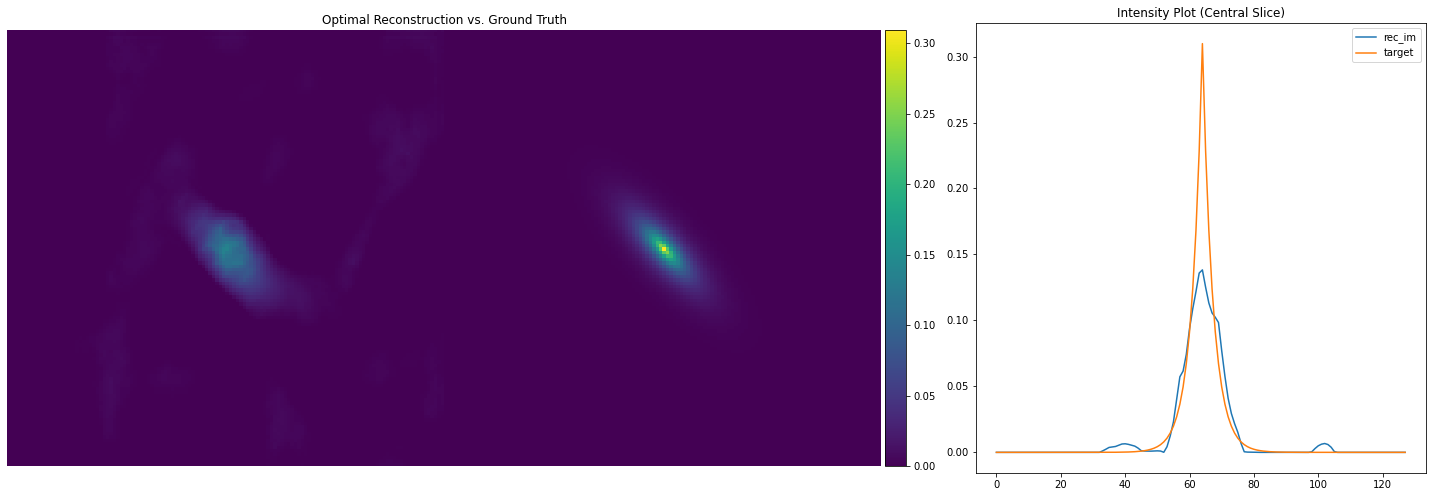

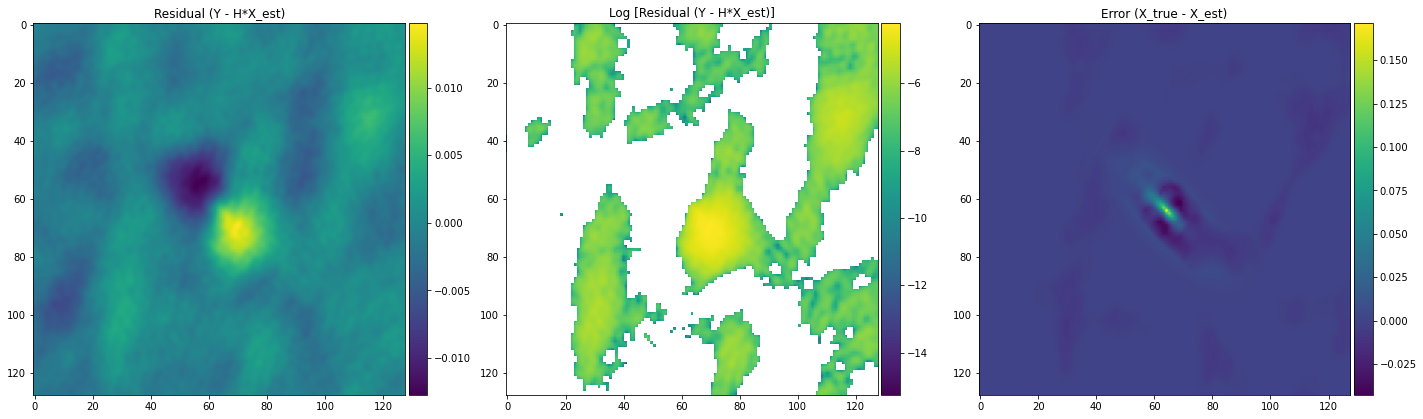

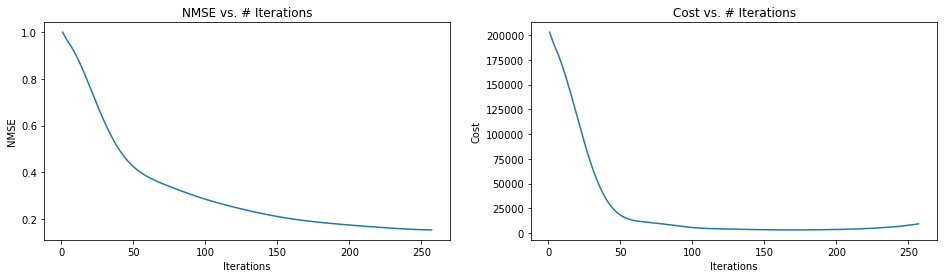


Minimum NMSE = 0.15251284837722778 (at [257] iterations)
Minimum Cost = 3325.704345703125 (at [170] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1590



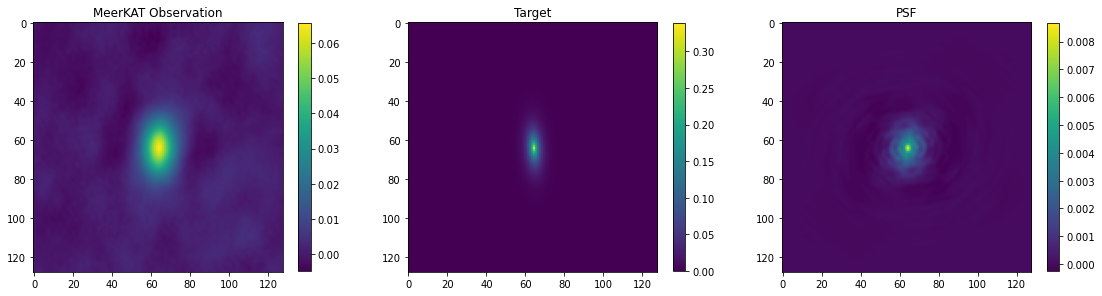

SNR (in Direct Space) = 34.862975821434276
Noise Std (in Direct Space) = 0.0018837610288057476
PSF Flux =  1.0000002



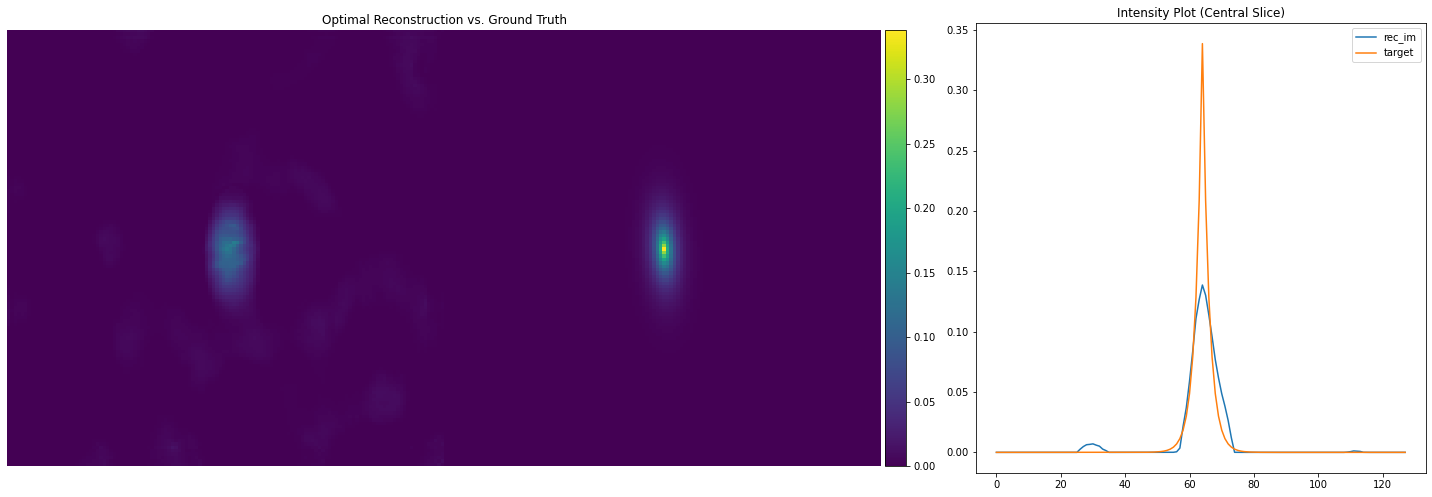

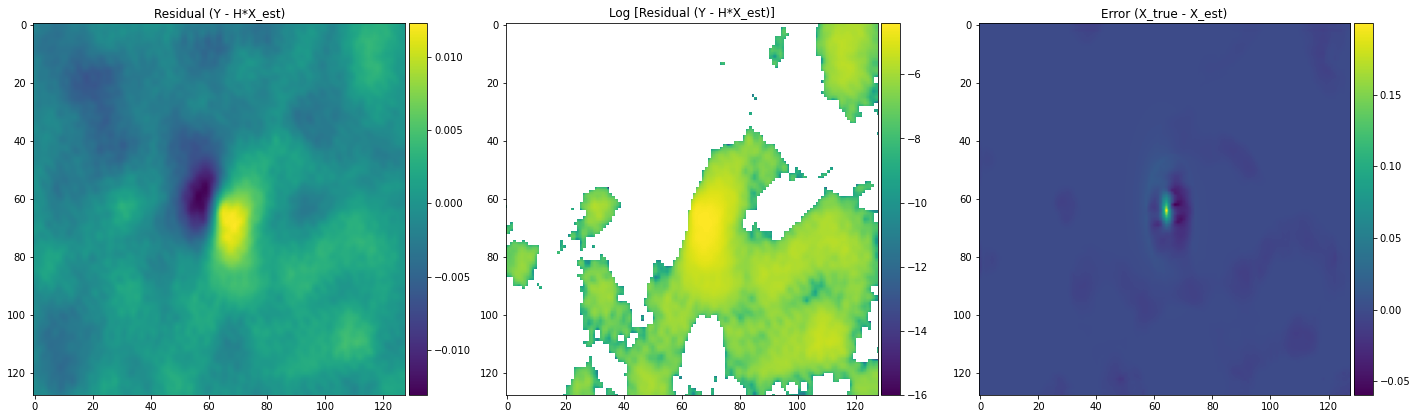

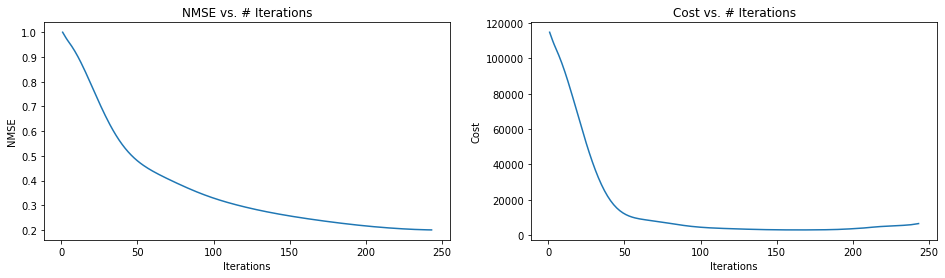


Minimum NMSE = 0.2003578245639801 (at [243] iterations)
Minimum Cost = 2970.691650390625 (at [165] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1580



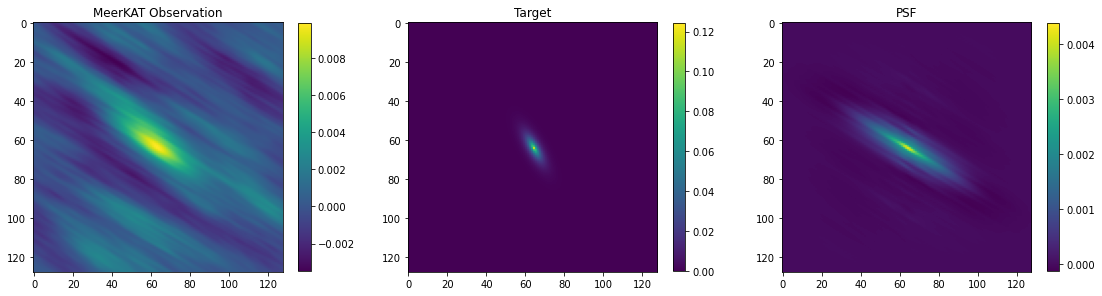

SNR (in Direct Space) = 7.04412067454325
Noise Std (in Direct Space) = 0.001400125631969422
PSF Flux =  0.9999999



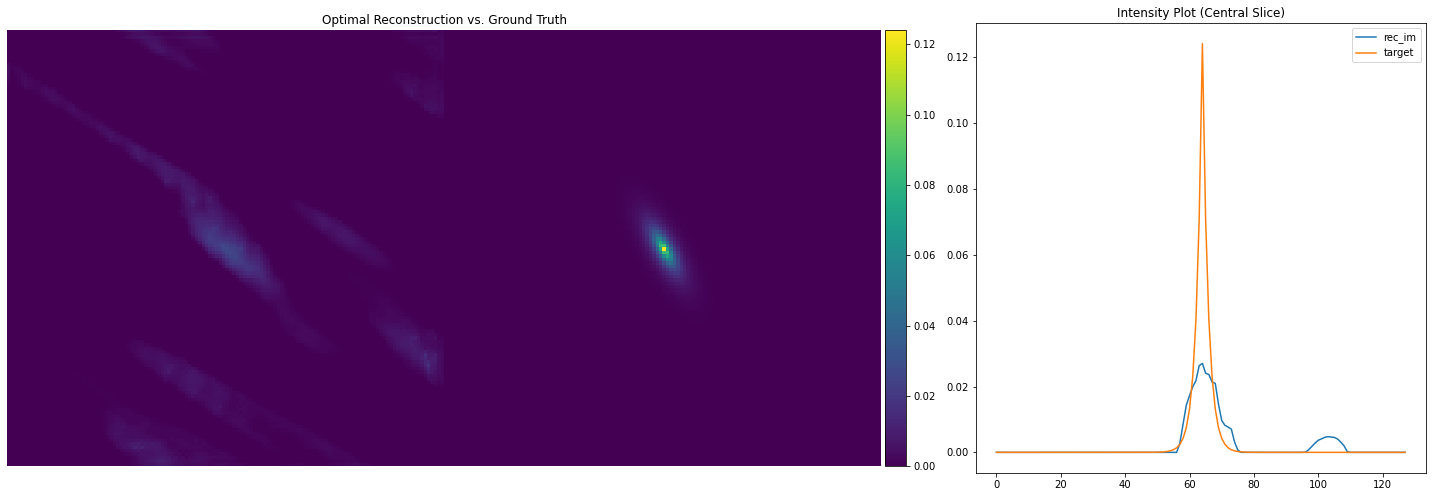

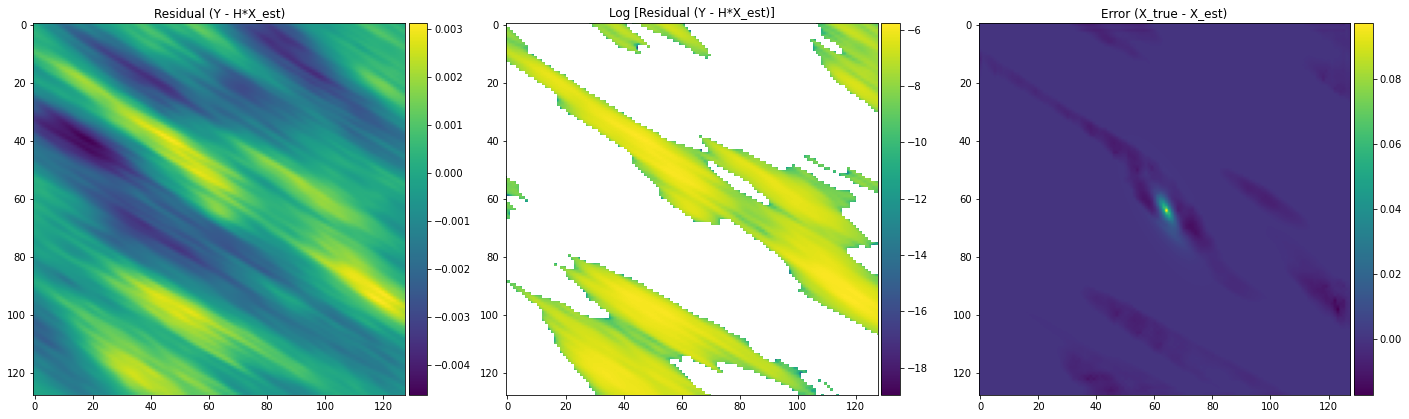

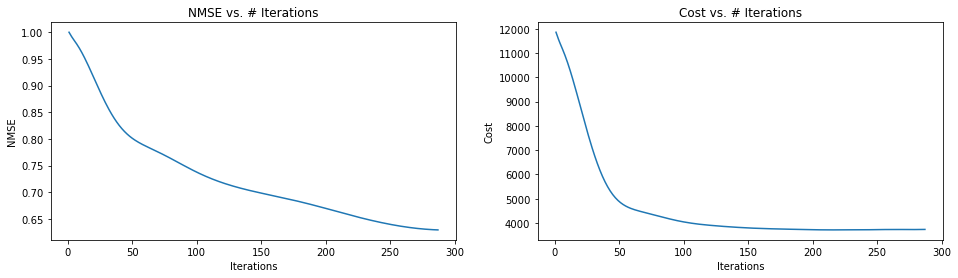


Minimum NMSE = 0.6292303204536438 (at [287] iterations)
Minimum Cost = 3713.22607421875 (at [213] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1570



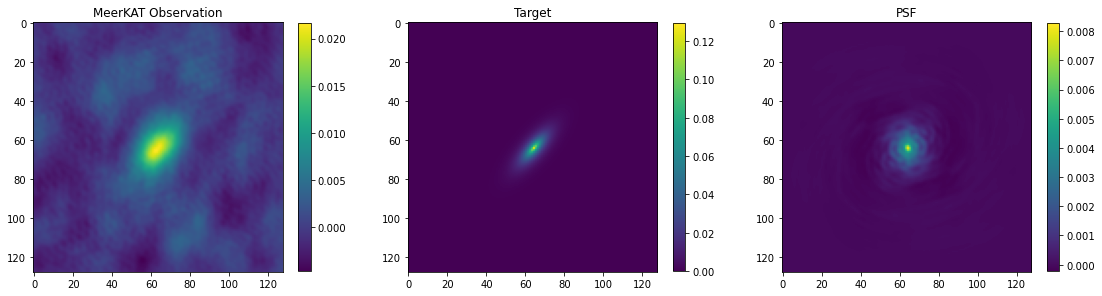

SNR (in Direct Space) = 12.730185204453113
Noise Std (in Direct Space) = 0.0016999895472312346
PSF Flux =  1.0000002



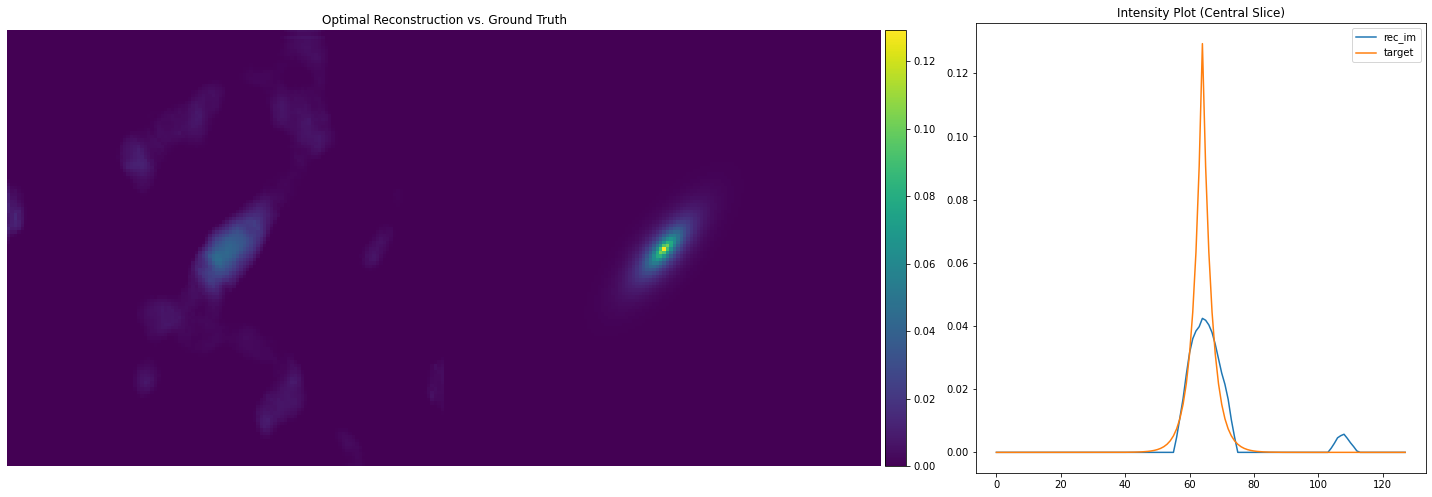

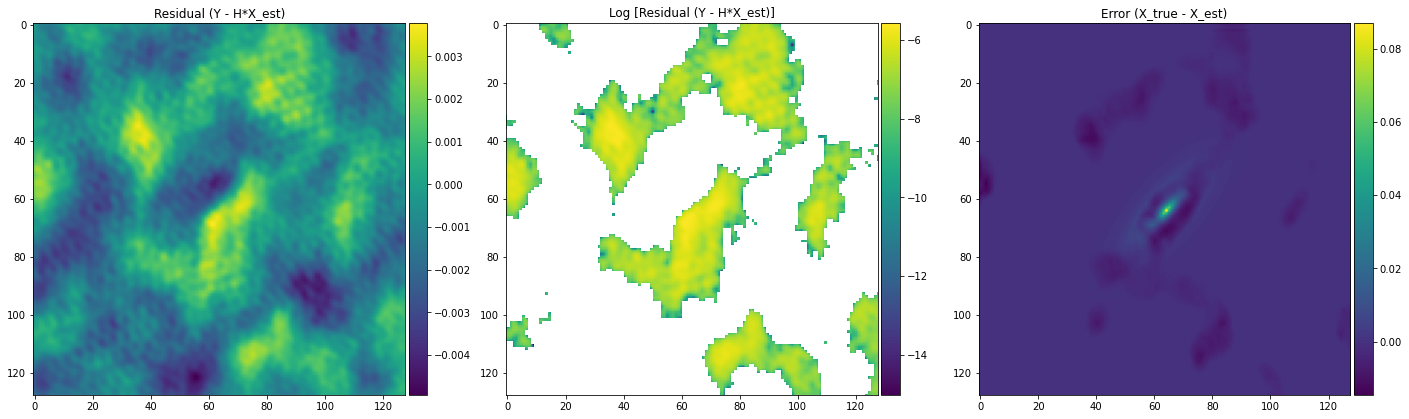

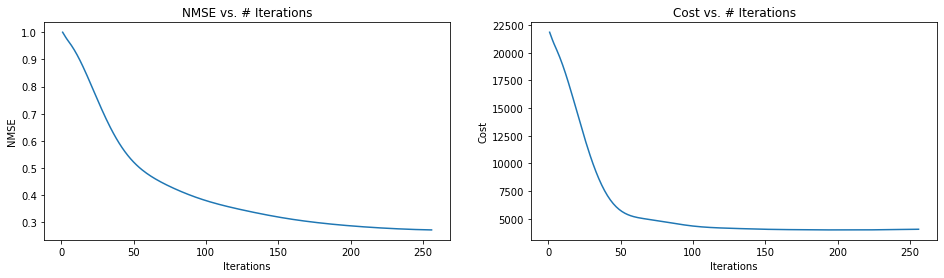


Minimum NMSE = 0.27270394563674927 (at [256] iterations)
Minimum Cost = 3995.866455078125 (at [204] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1560



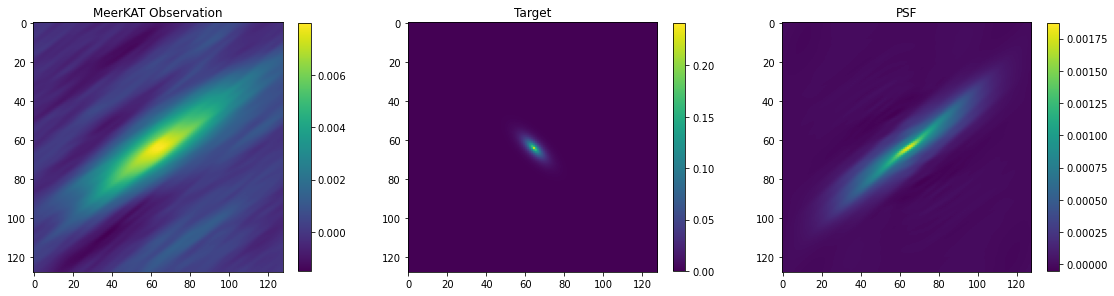

SNR (in Direct Space) = 9.504875259783834
Noise Std (in Direct Space) = 0.0008409928722074255
PSF Flux =  1.0000001



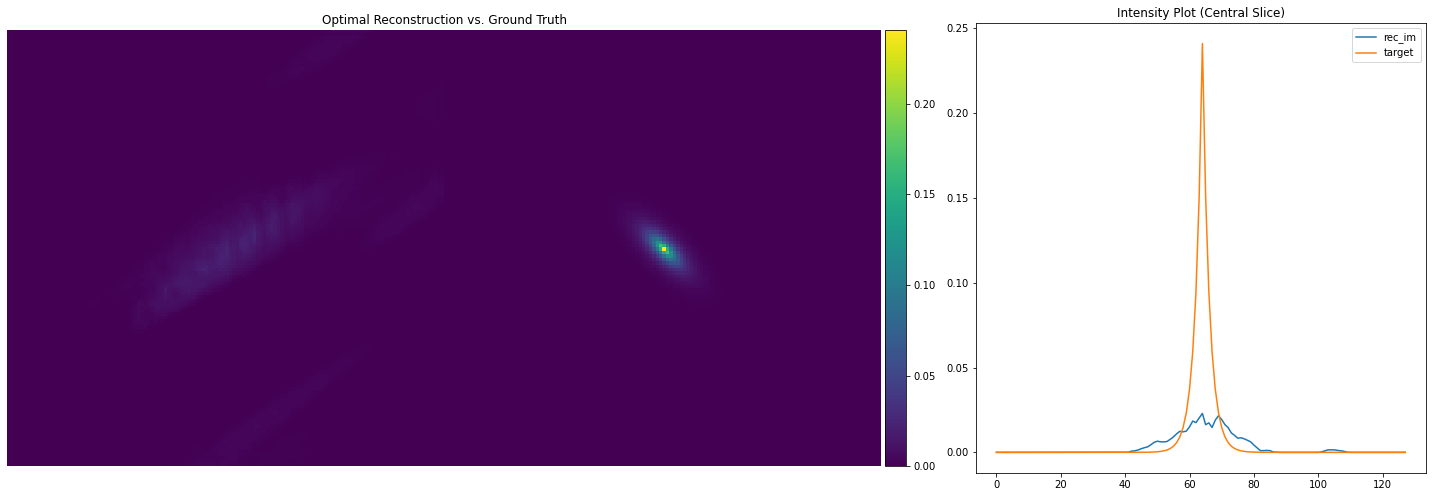

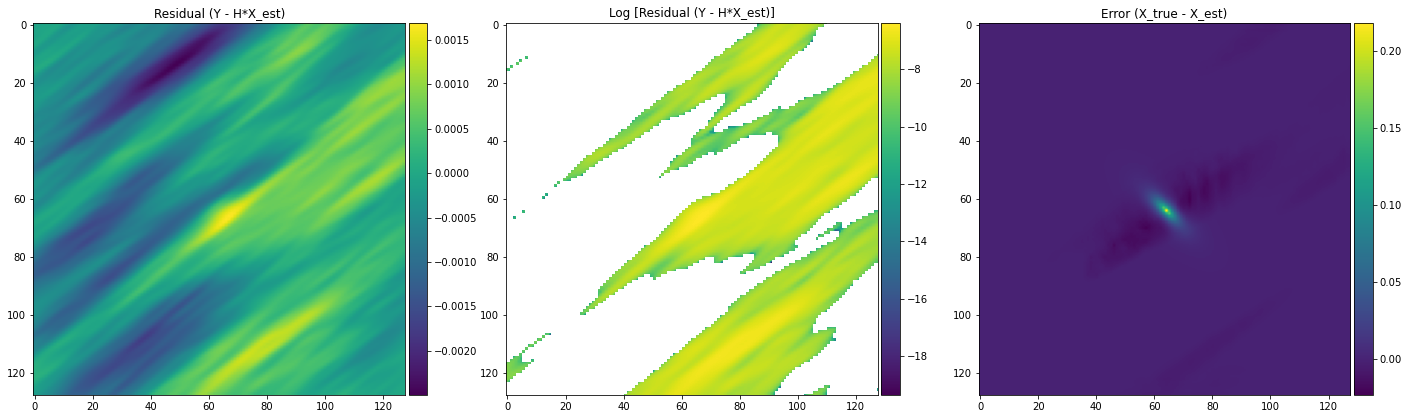

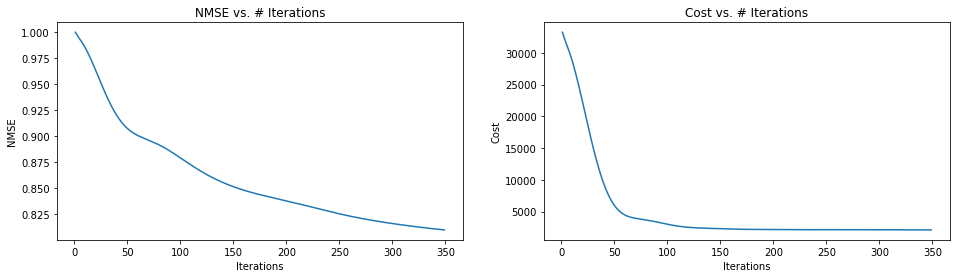


Minimum NMSE = 0.8099313974380493 (at [349] iterations)
Minimum Cost = 2116.939697265625 (at [349] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1550



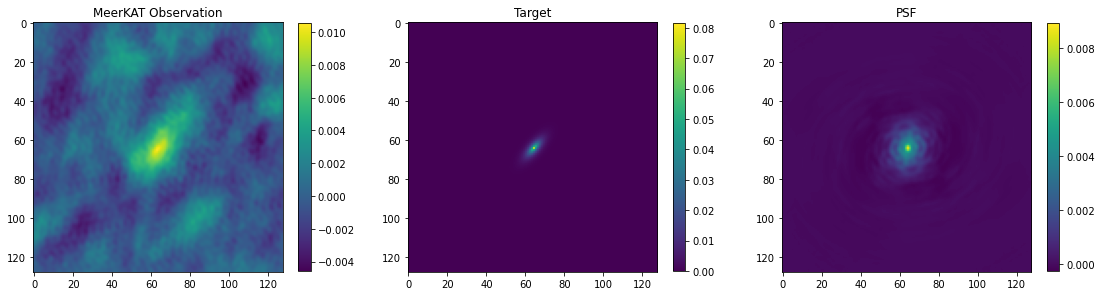

SNR (in Direct Space) = 6.977992074271551
Noise Std (in Direct Space) = 0.0015112374237505719
PSF Flux =  1.0000005



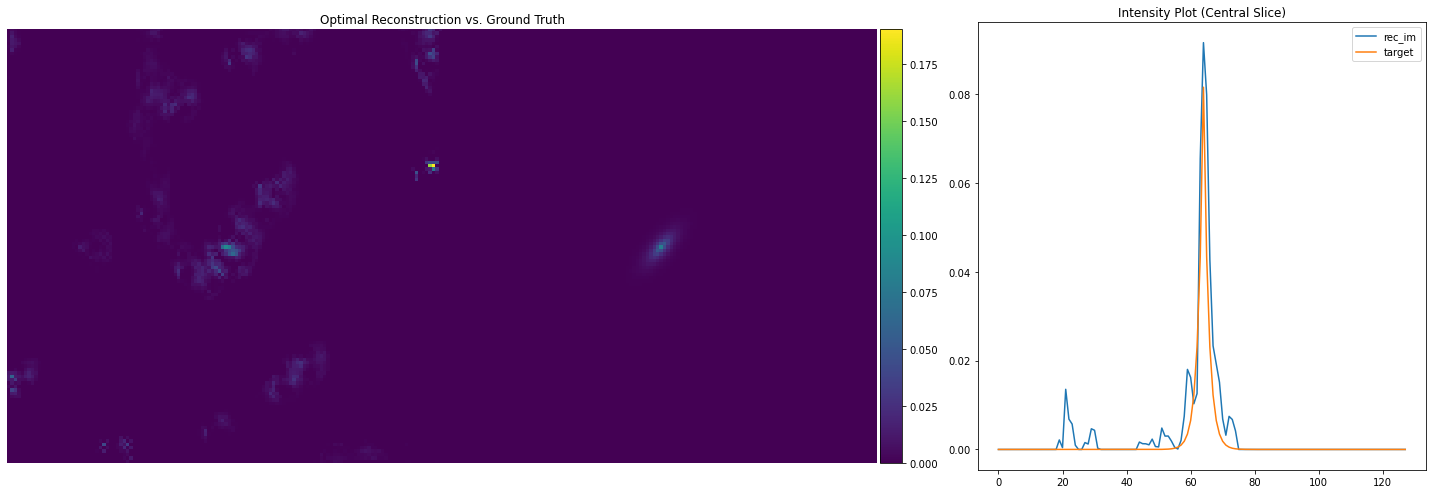

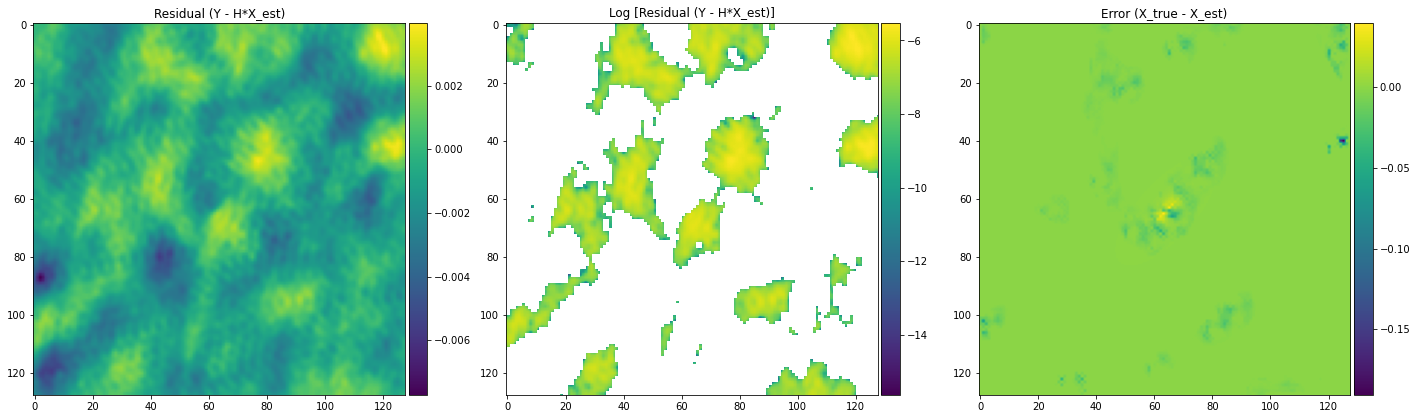

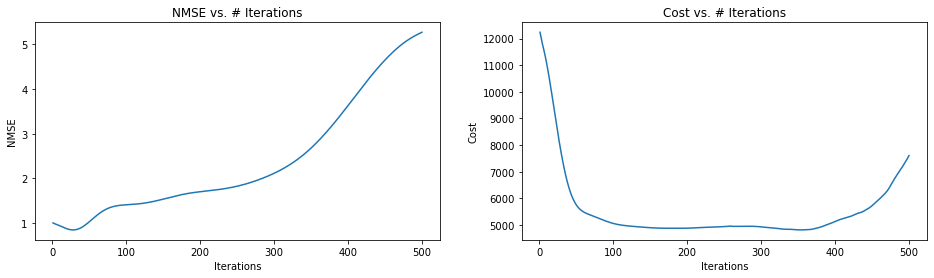


Minimum NMSE = 0.8429398536682129 (at [28] iterations)
Minimum Cost = 4816.6123046875 (at [353] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1540



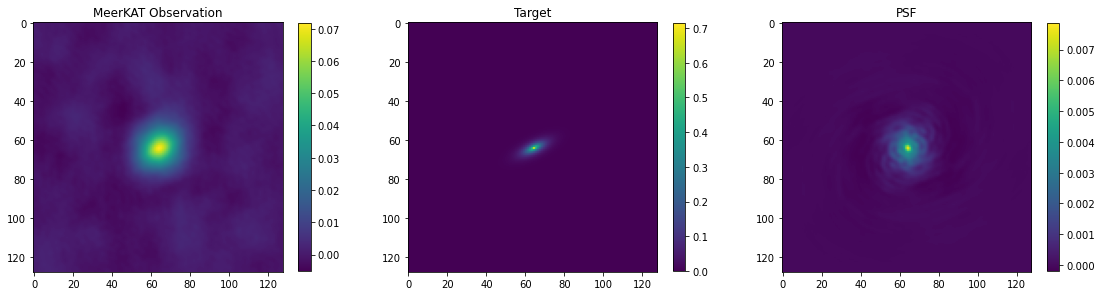

SNR (in Direct Space) = 43.46343641648287
Noise Std (in Direct Space) = 0.00164997238679789
PSF Flux =  0.99999994



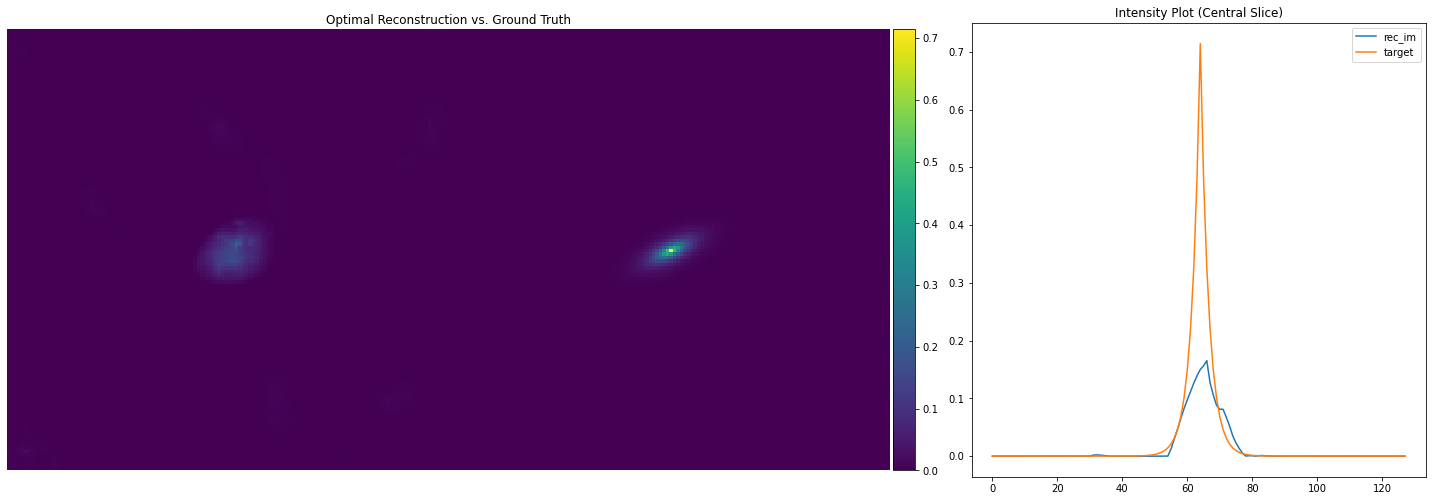

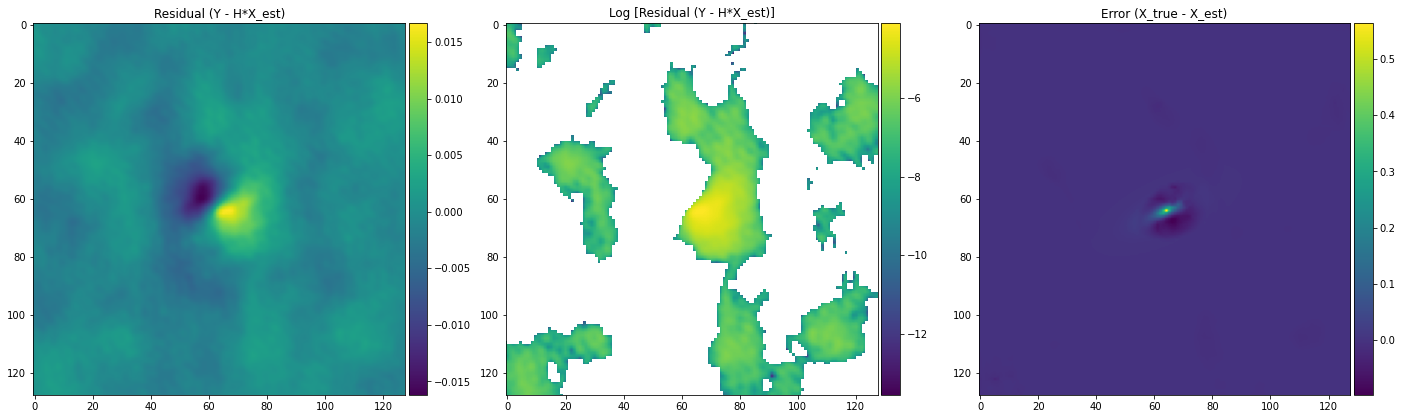

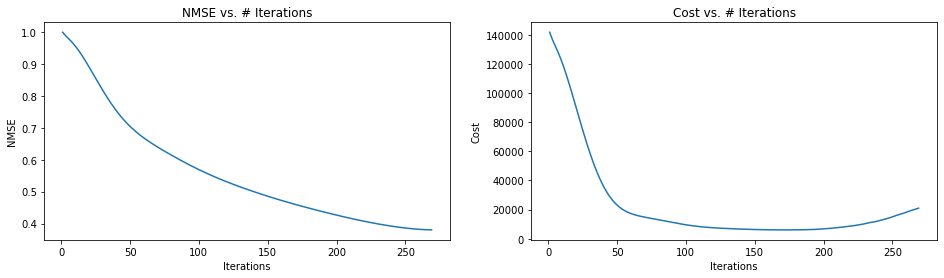


Minimum NMSE = 0.37993261218070984 (at [269] iterations)
Minimum Cost = 6053.2001953125 (at [169] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1530



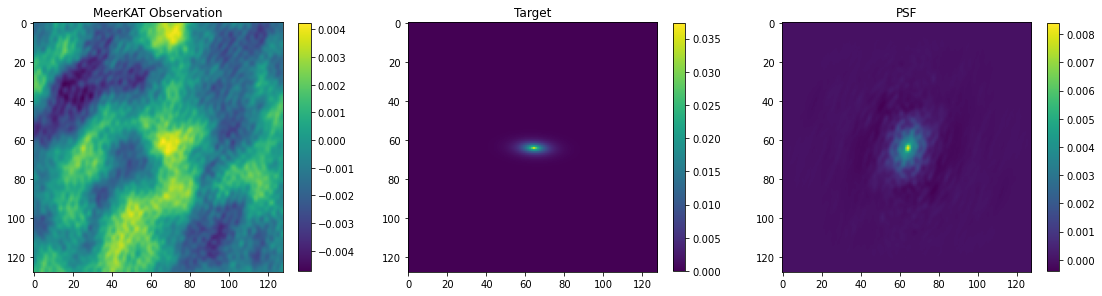

SNR (in Direct Space) = 2.348022111468689
Noise Std (in Direct Space) = 0.001798486543446779
PSF Flux =  1.0



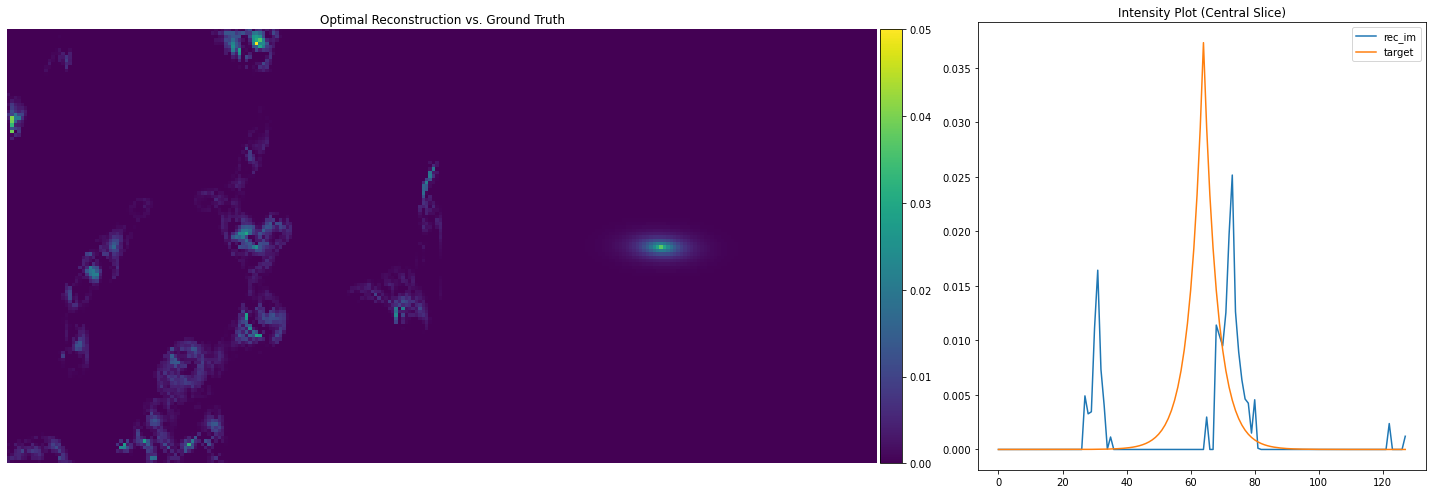

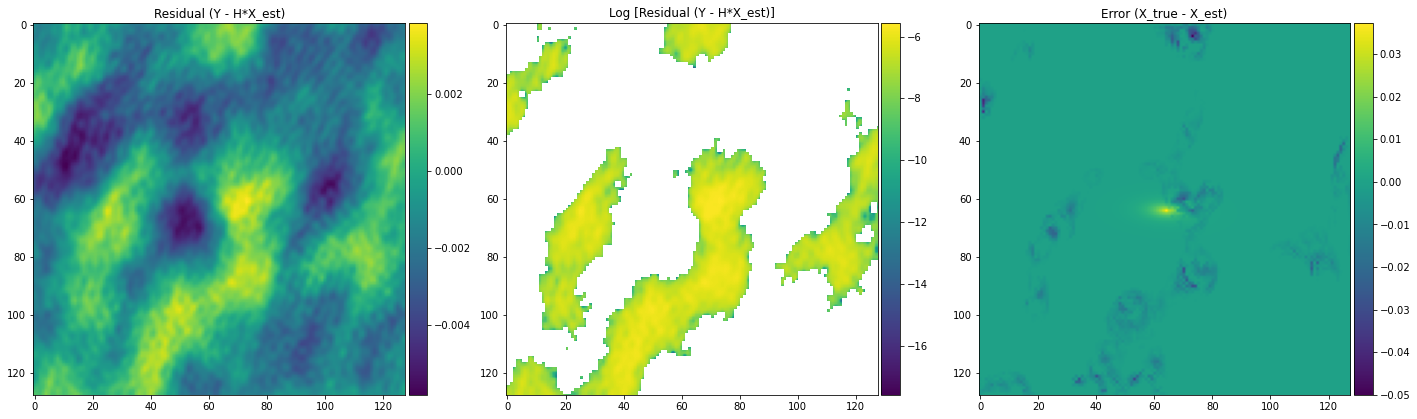

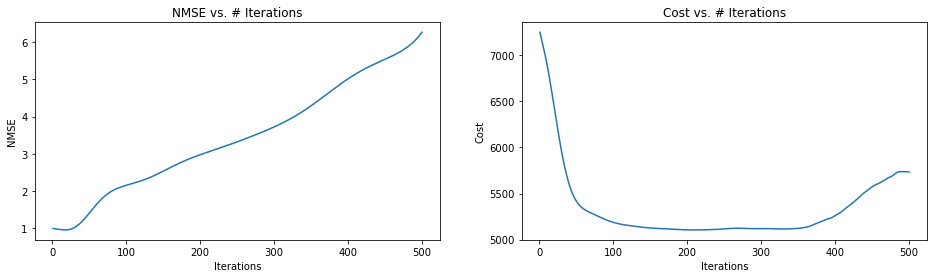


Minimum NMSE = 0.9604188203811646 (at [17] iterations)
Minimum Cost = 5105.5673828125 (at [208] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1520



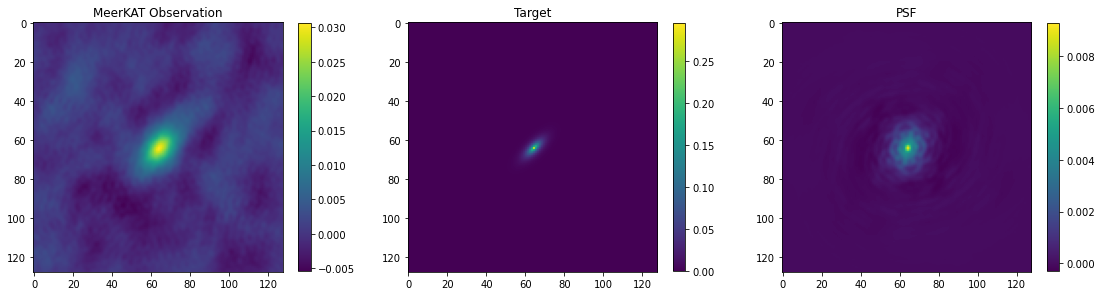

SNR (in Direct Space) = 17.357208363925498
Noise Std (in Direct Space) = 0.0017633358836872503
PSF Flux =  1.0000004



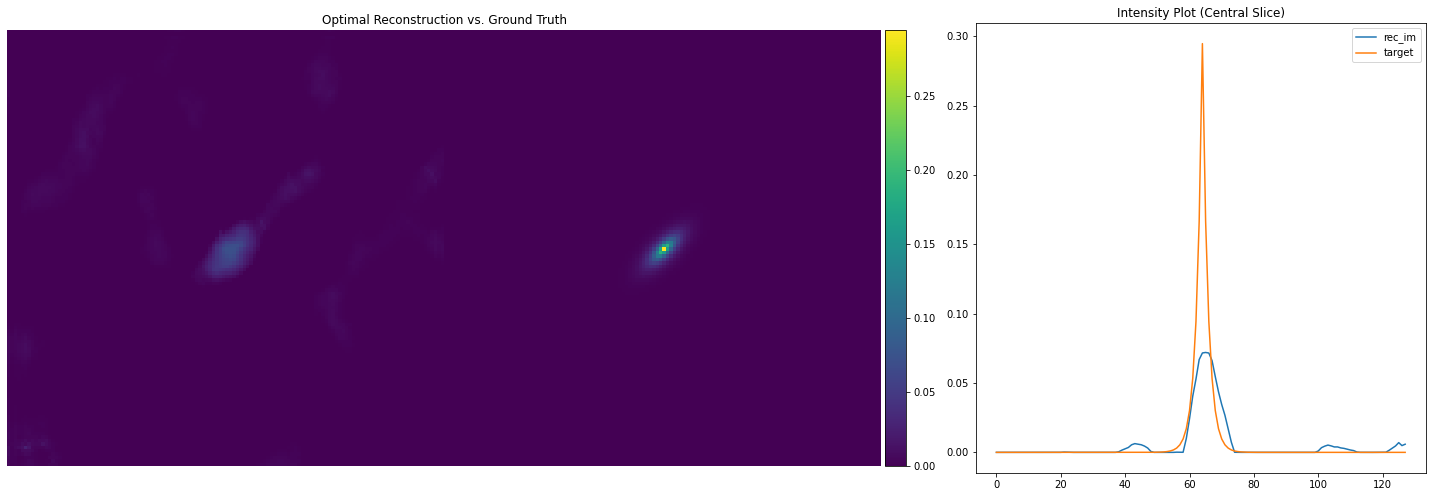

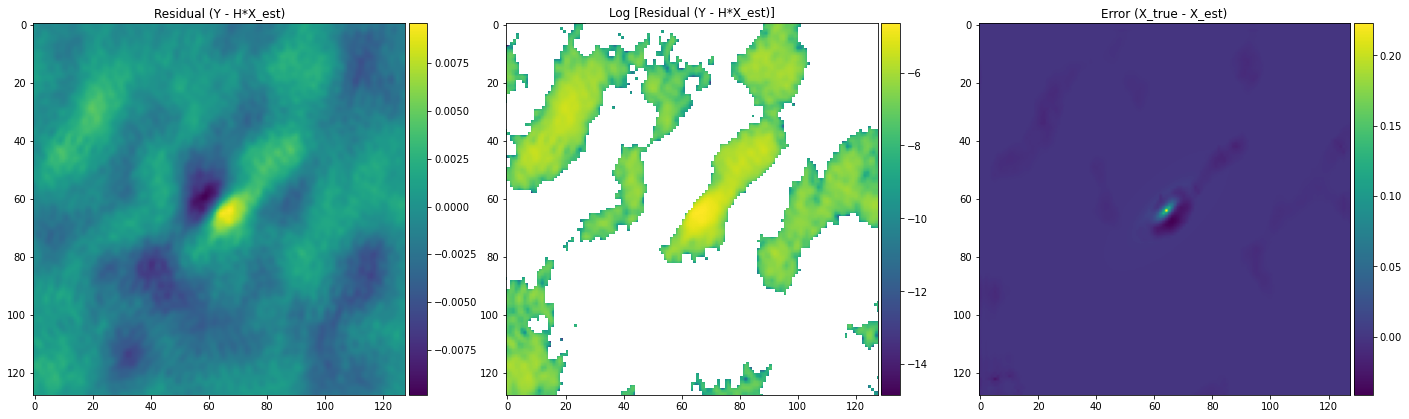

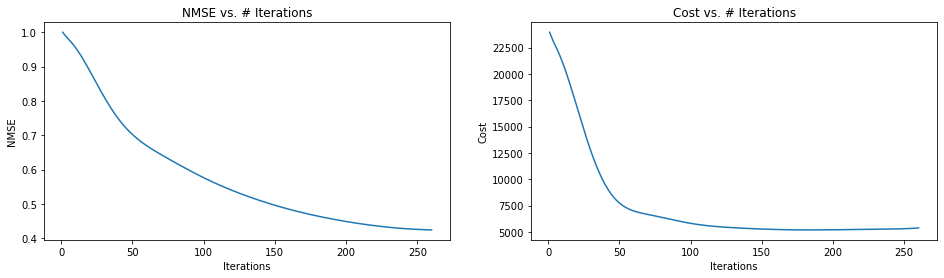


Minimum NMSE = 0.42446982860565186 (at [260] iterations)
Minimum Cost = 5196.39208984375 (at [182] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1510



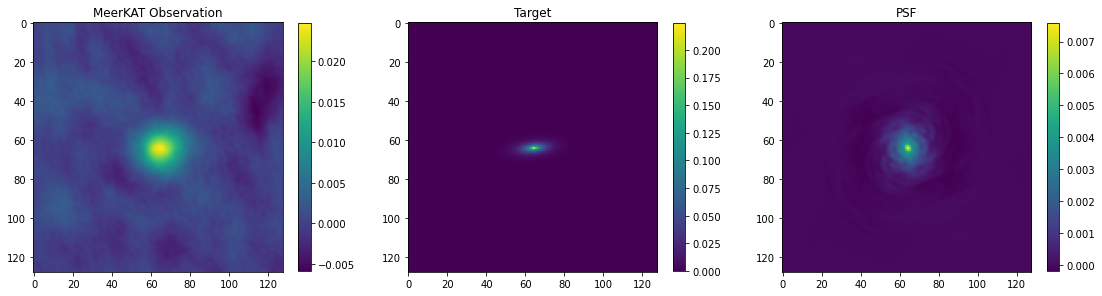

SNR (in Direct Space) = 18.821732679901896
Noise Std (in Direct Space) = 0.0013129996084724552
PSF Flux =  0.9999999



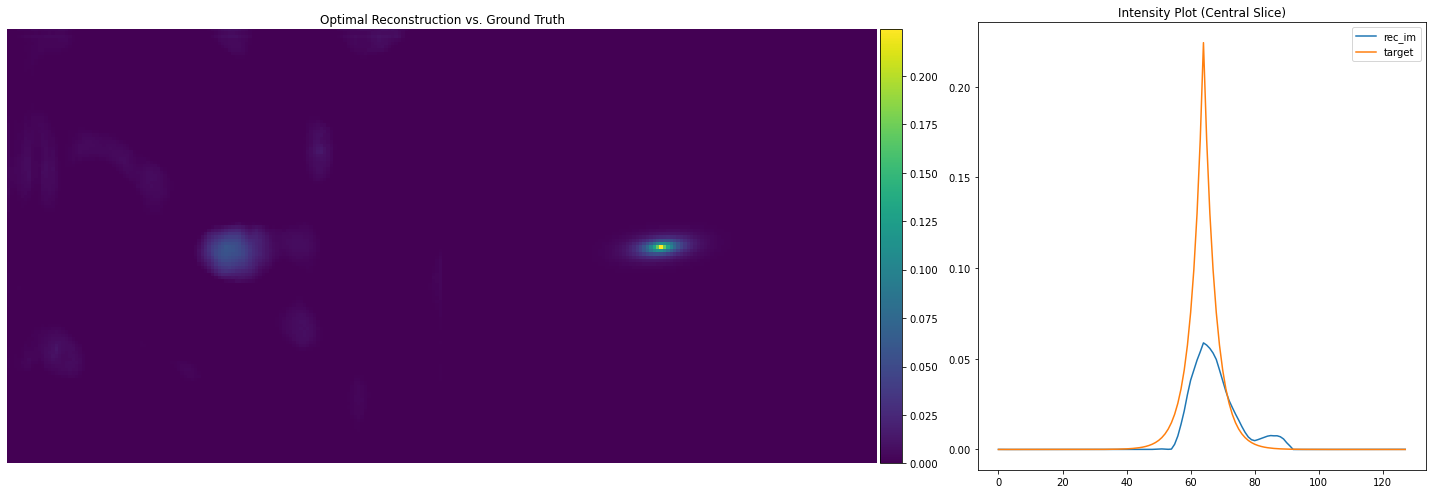

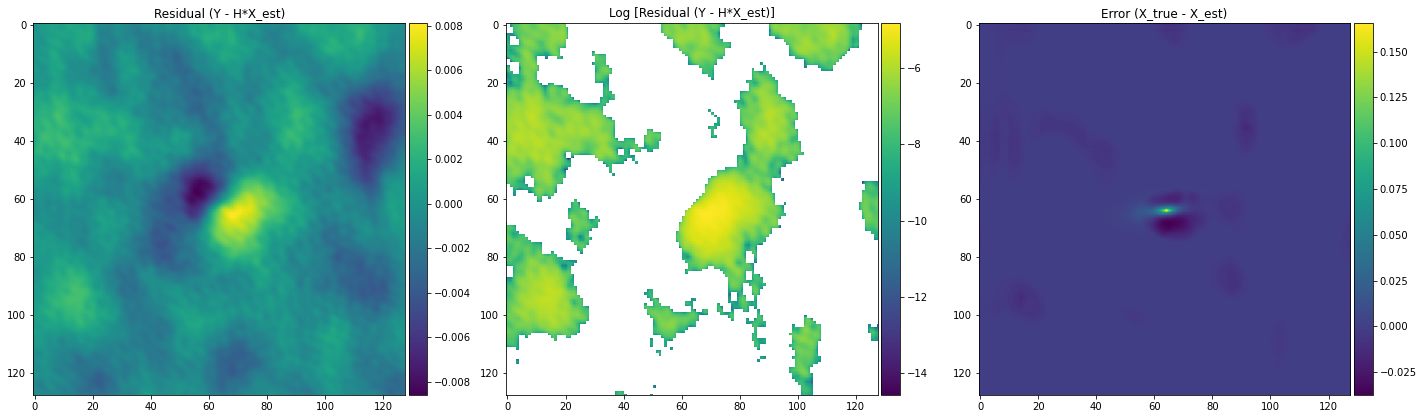

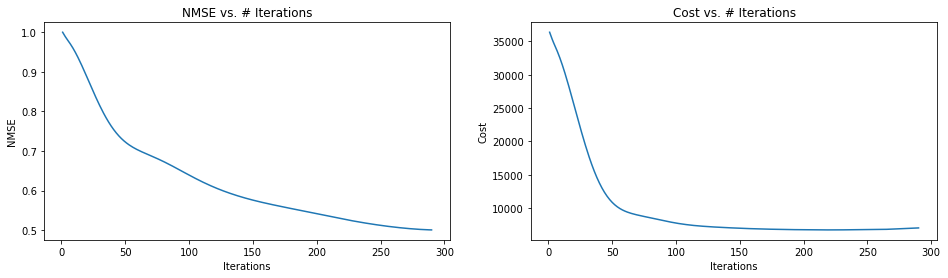


Minimum NMSE = 0.5006030201911926 (at [290] iterations)
Minimum Cost = 6707.92919921875 (at [221] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1500



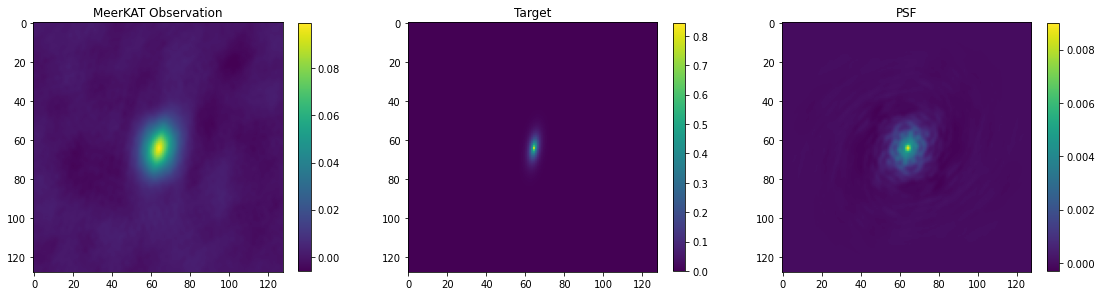

SNR (in Direct Space) = 52.8675477407672
Noise Std (in Direct Space) = 0.0018754908538889138
PSF Flux =  0.9999999



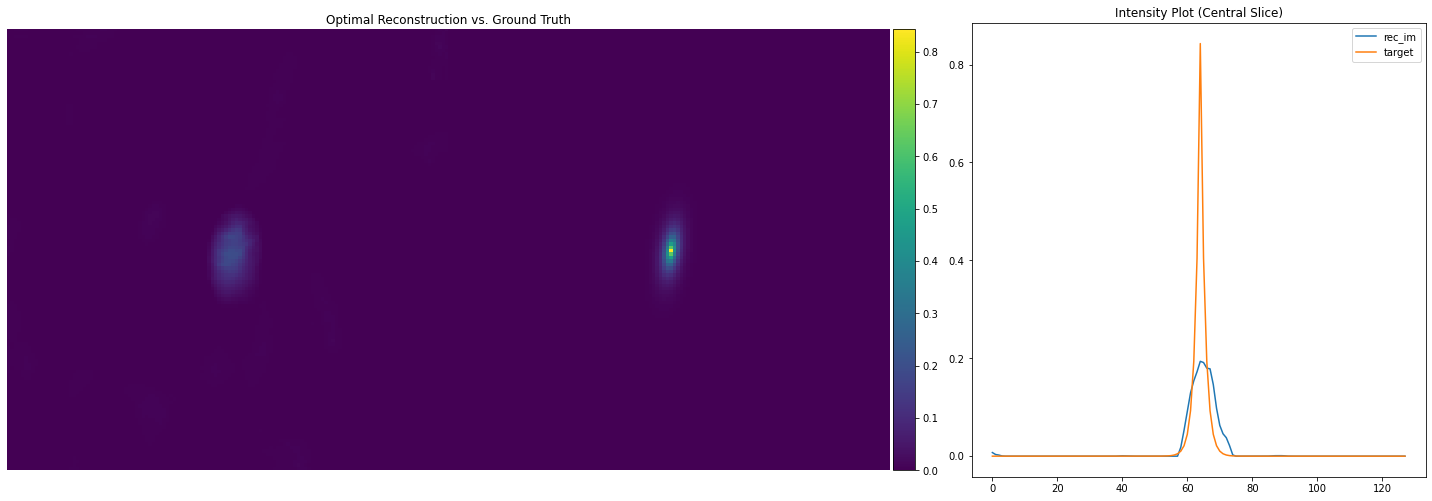

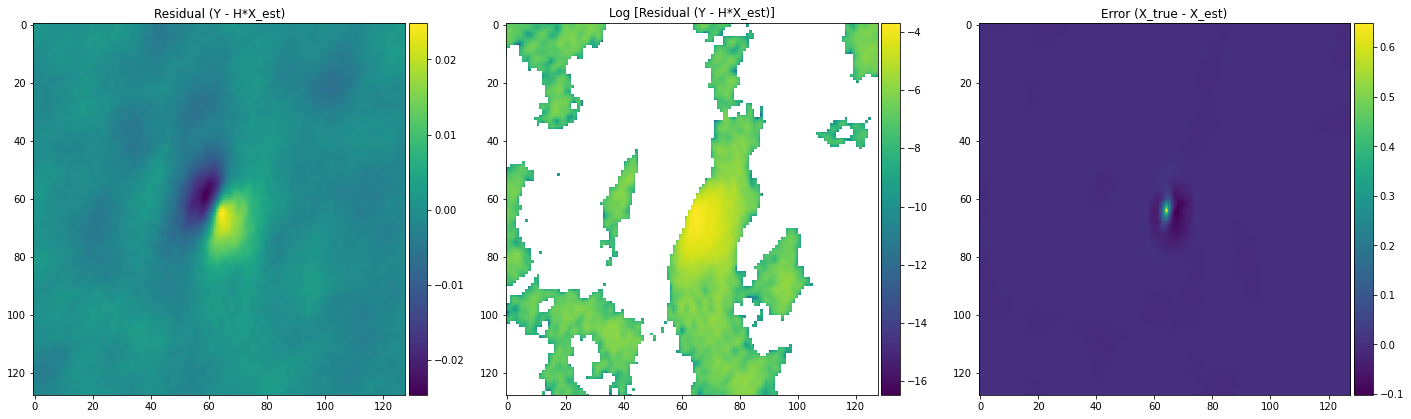

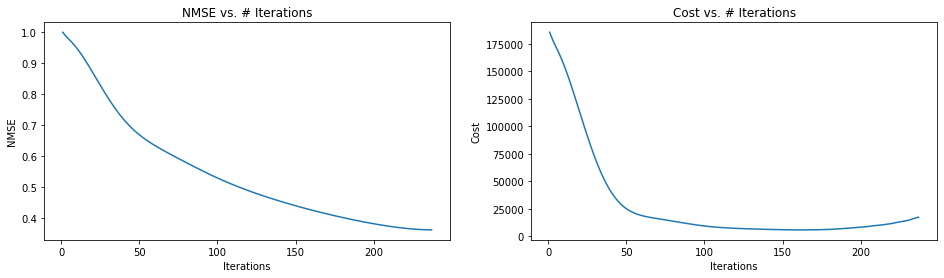


Minimum NMSE = 0.36165162920951843 (at [237] iterations)
Minimum Cost = 5903.400390625 (at [162] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1490



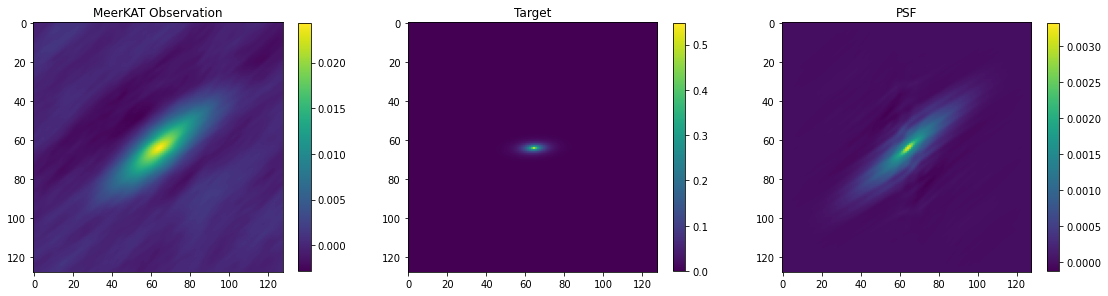

SNR (in Direct Space) = 27.20622716013849
Noise Std (in Direct Space) = 0.0008935028562555089
PSF Flux =  1.0000002



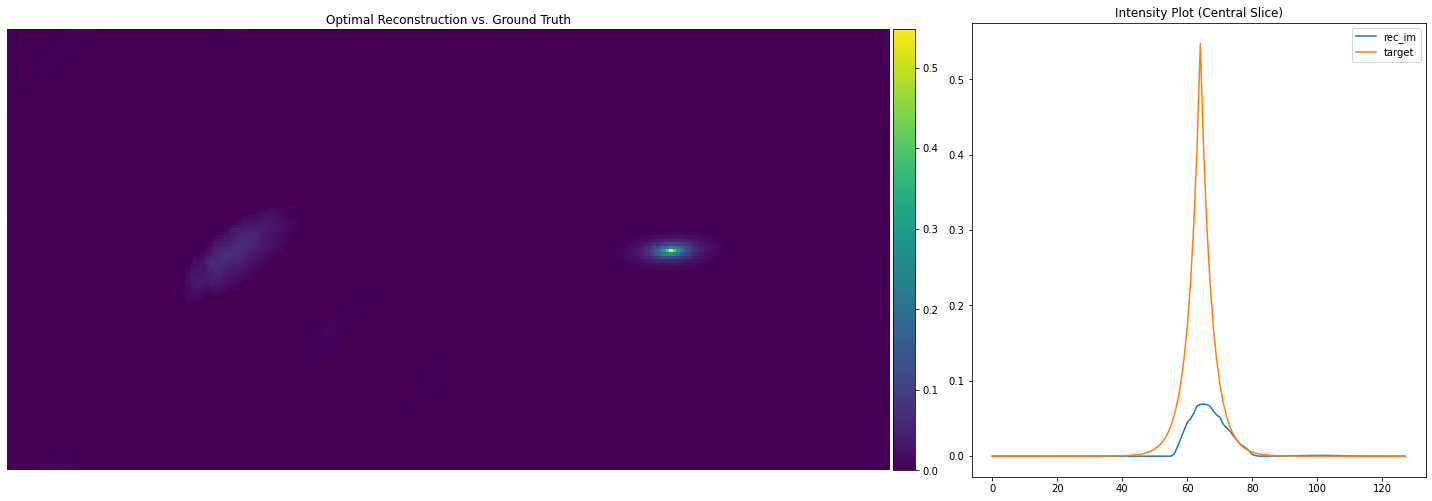

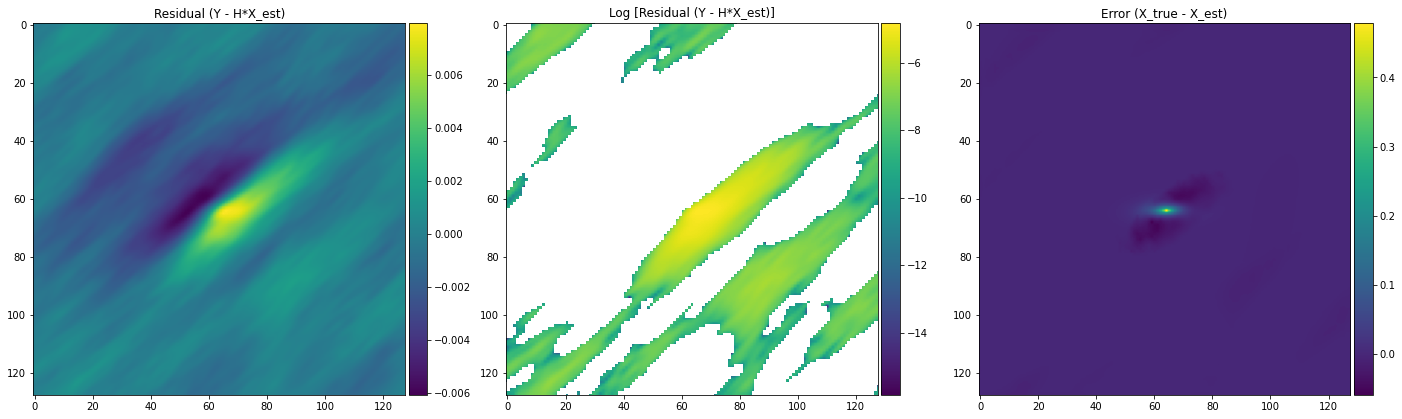

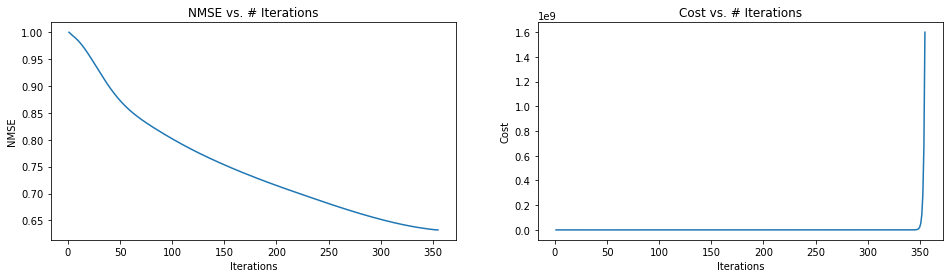


Minimum NMSE = 0.6323134899139404 (at [355] iterations)
Minimum Cost = 8137.02392578125 (at [276] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1480



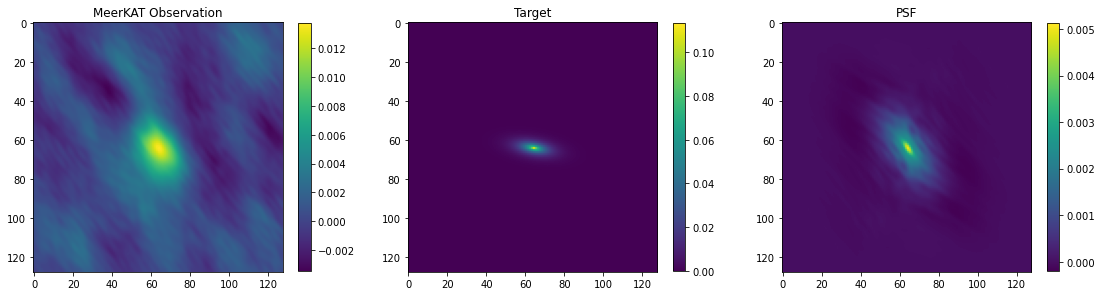

SNR (in Direct Space) = 9.155669446587432
Noise Std (in Direct Space) = 0.0014989124191459268
PSF Flux =  0.99999994



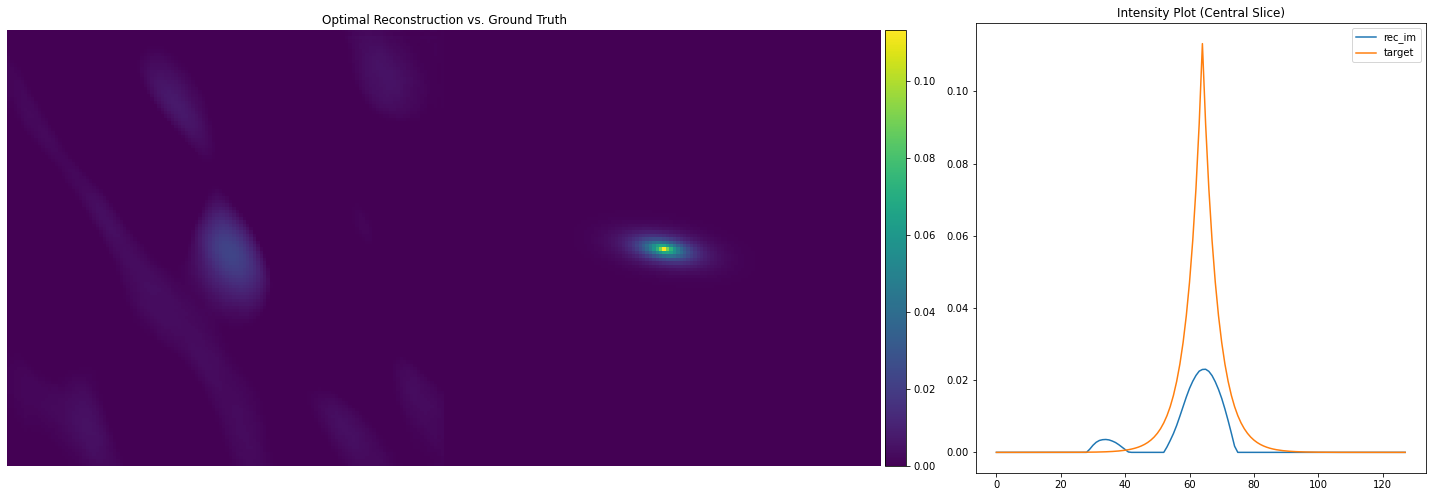

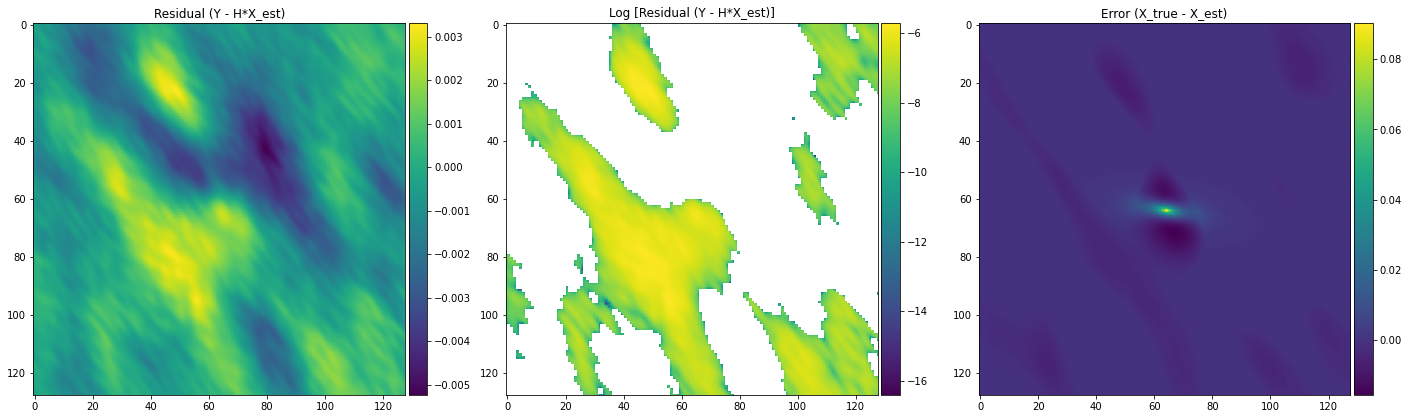

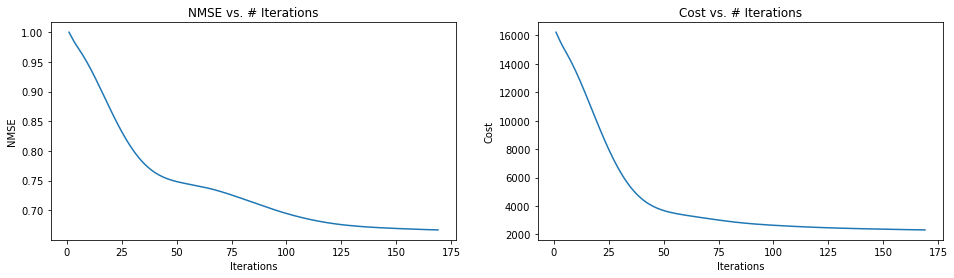


Minimum NMSE = 0.66695636510849 (at [169] iterations)
Minimum Cost = 2317.5634765625 (at [169] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1470



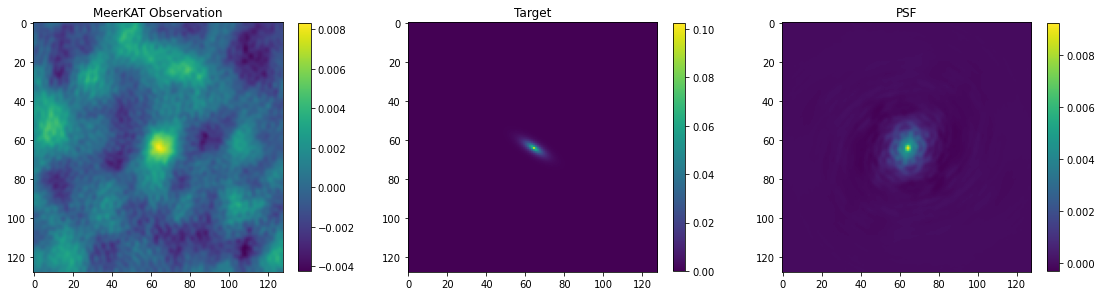

SNR (in Direct Space) = 5.51895787858728
Noise Std (in Direct Space) = 0.0015049764546565712
PSF Flux =  1.0000005



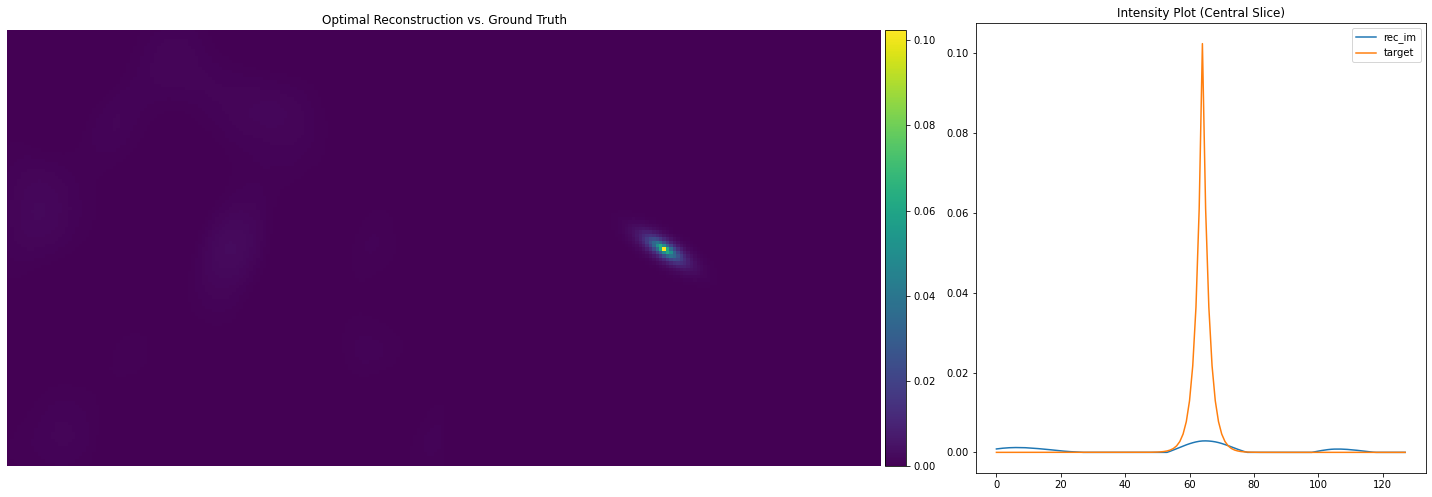

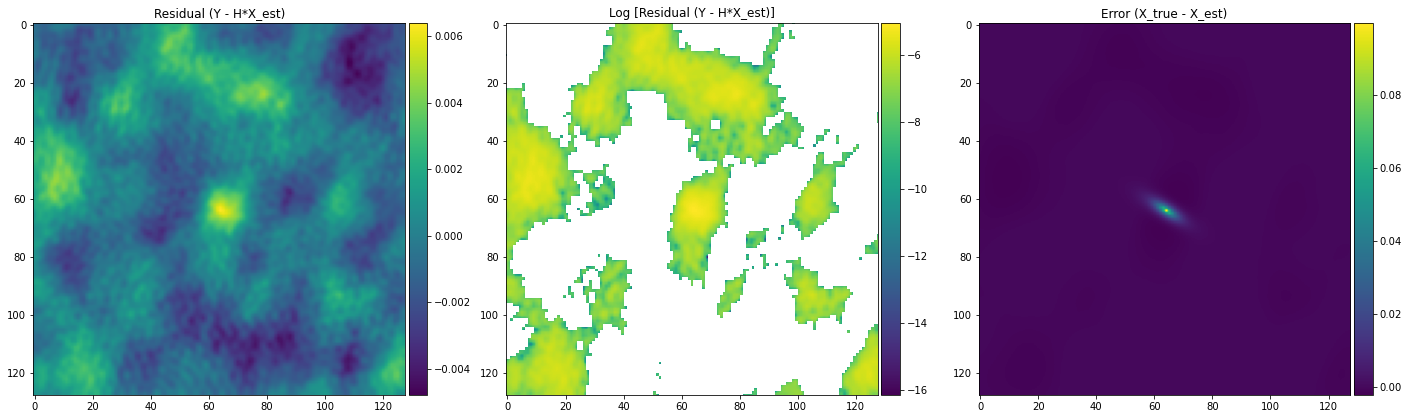

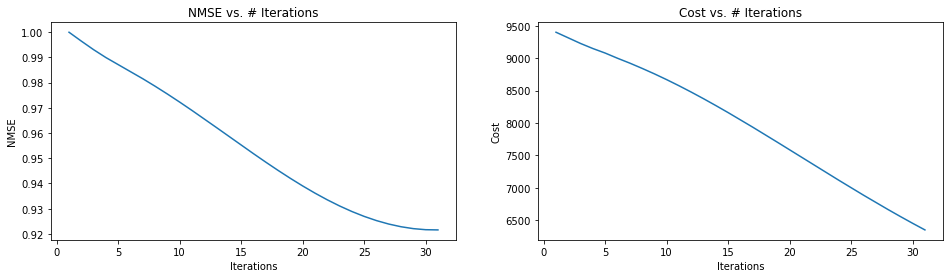


Minimum NMSE = 0.9215809106826782 (at [31] iterations)
Minimum Cost = 6351.0205078125 (at [31] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1460



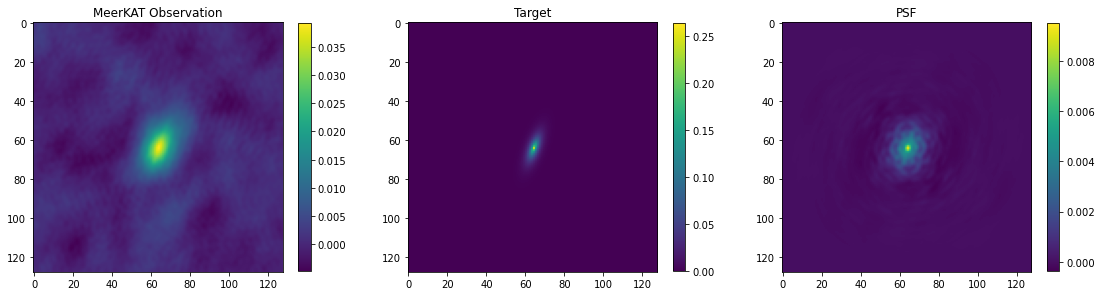

SNR (in Direct Space) = 22.18919261102072
Noise Std (in Direct Space) = 0.0017655325302388517
PSF Flux =  0.99999964



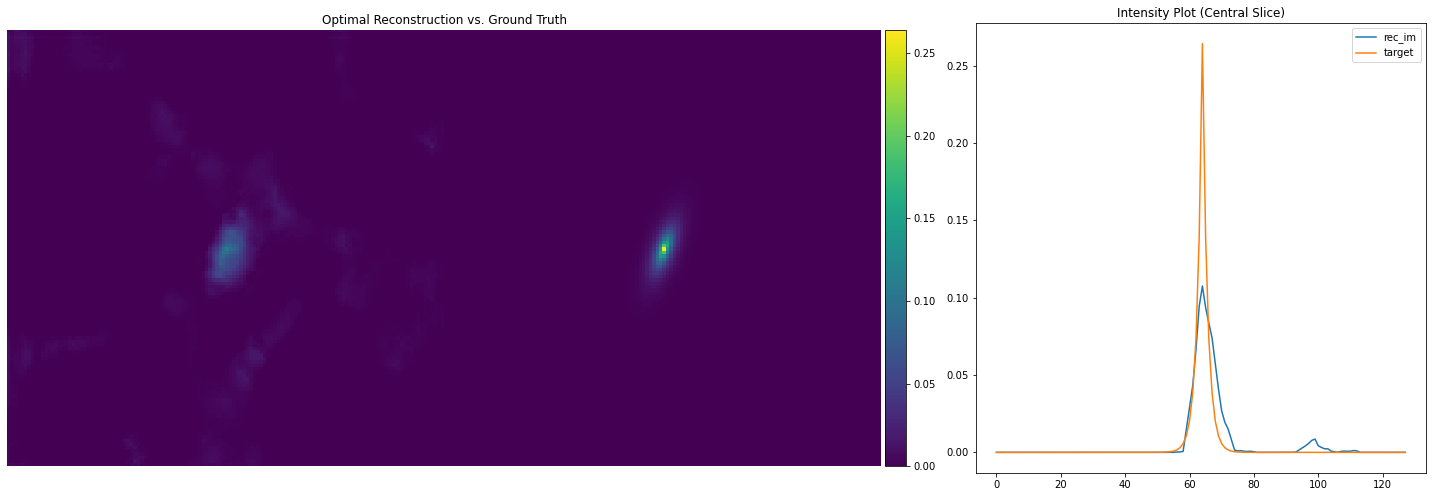

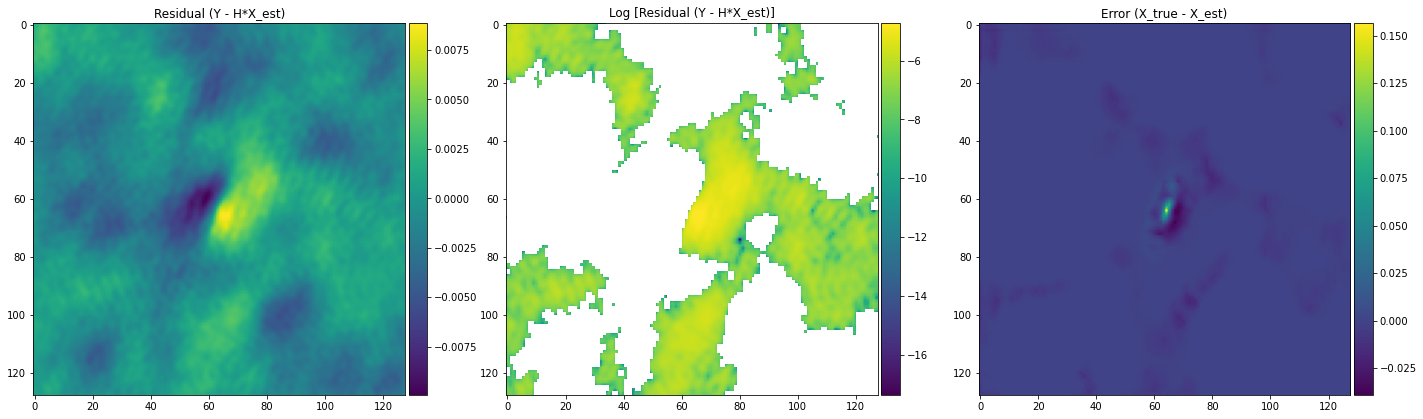

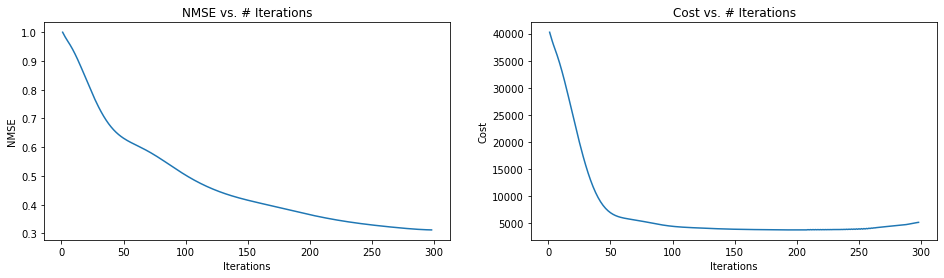


Minimum NMSE = 0.3121524751186371 (at [298] iterations)
Minimum Cost = 3812.059814453125 (at [204] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1450



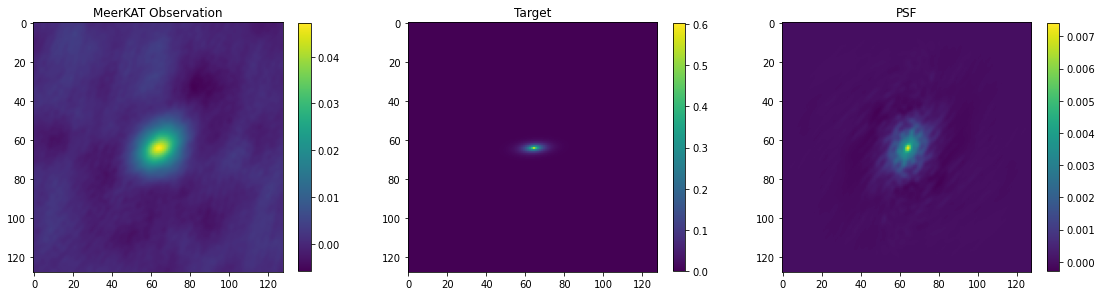

SNR (in Direct Space) = 26.991432429838127
Noise Std (in Direct Space) = 0.001747346809809096
PSF Flux =  1.0



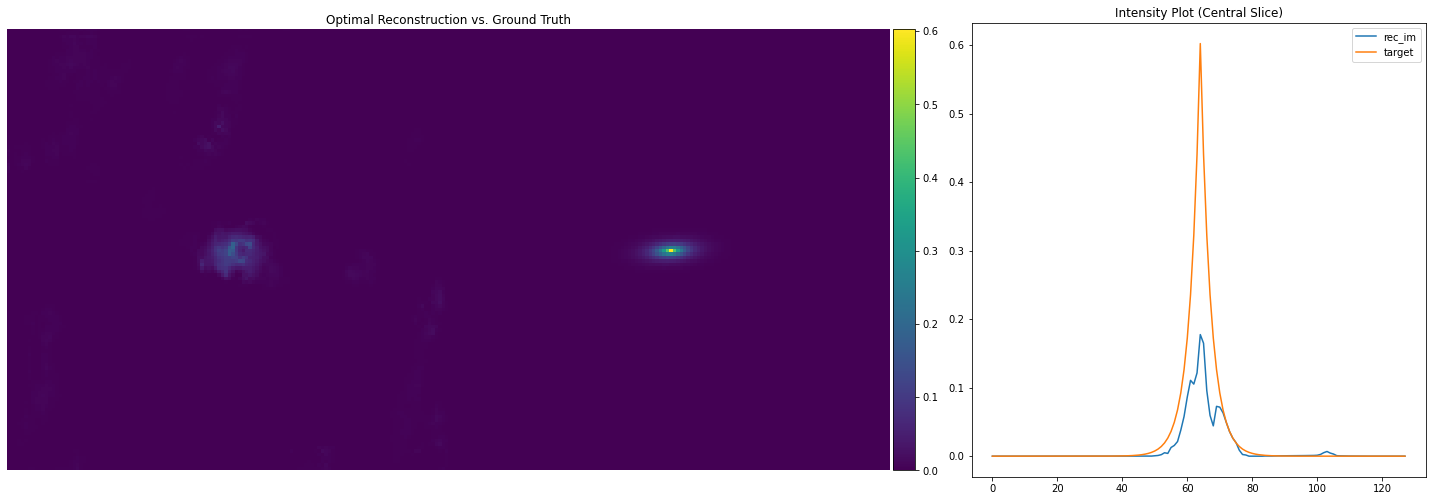

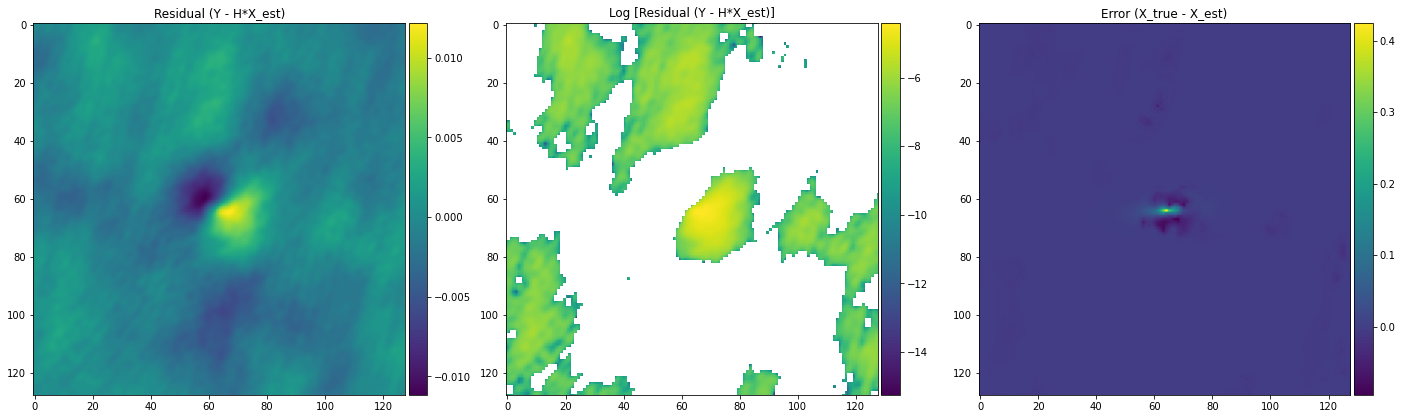

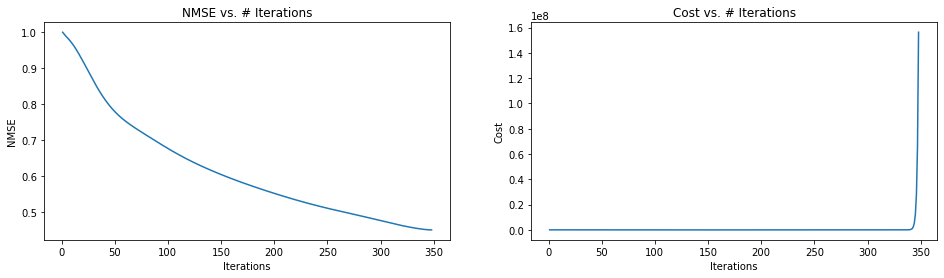


Minimum NMSE = 0.44960856437683105 (at [347] iterations)
Minimum Cost = 3944.07763671875 (at [200] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1440



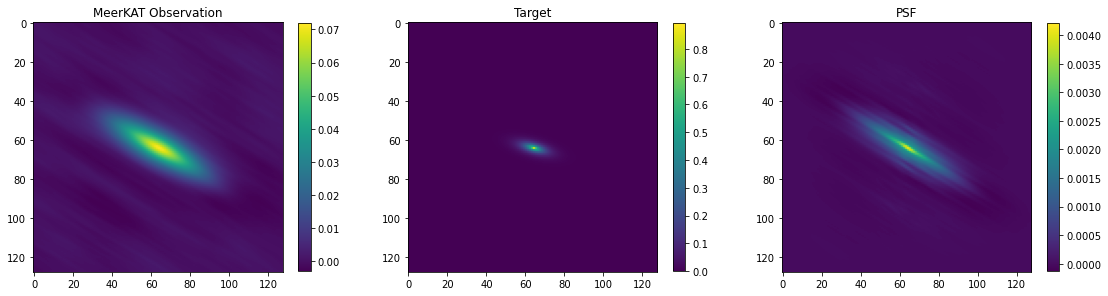

SNR (in Direct Space) = 66.1408892770529
Noise Std (in Direct Space) = 0.00108718246165663
PSF Flux =  0.99999964



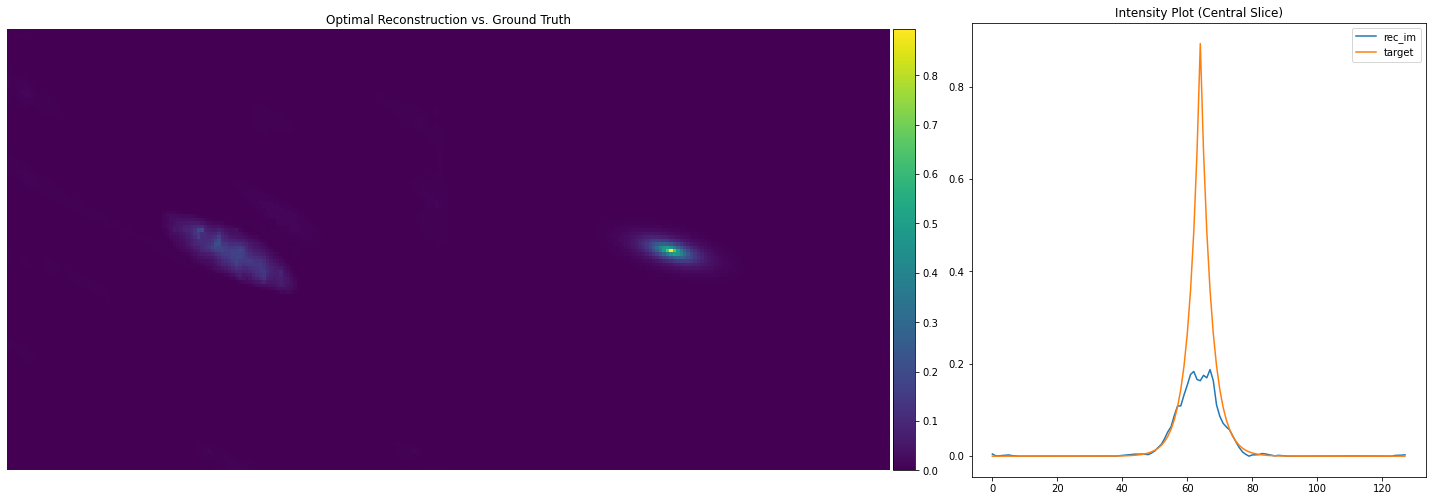

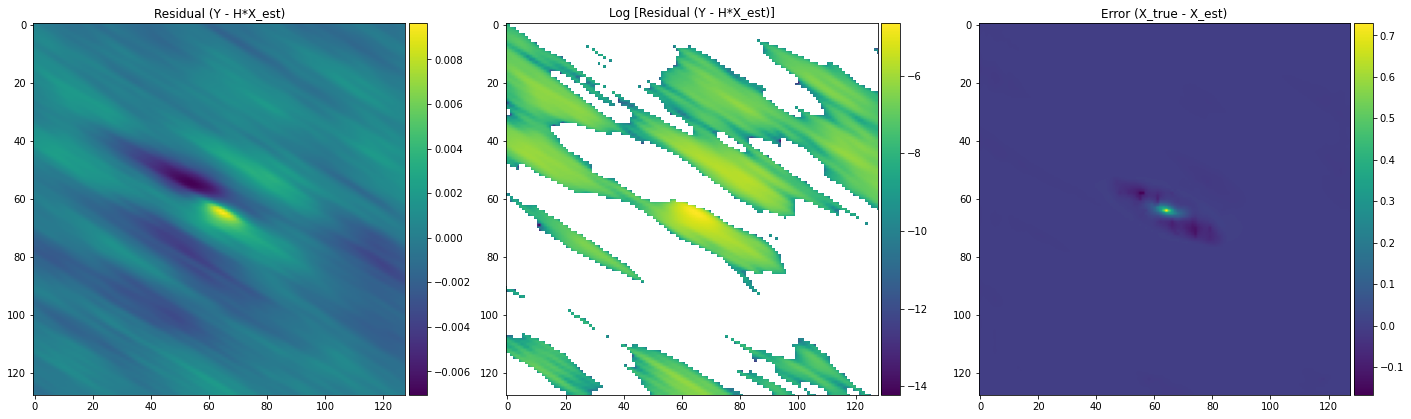

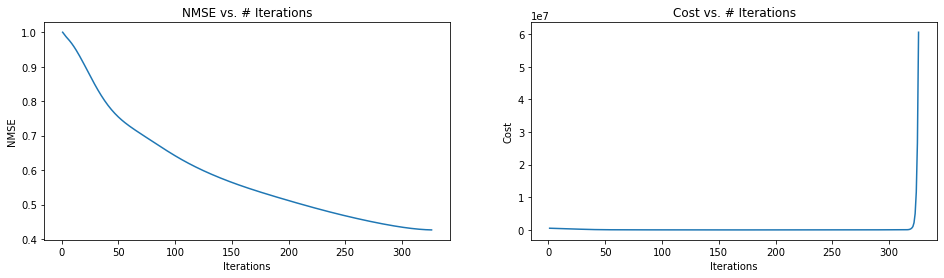


Minimum NMSE = 0.4264585077762604 (at [326] iterations)
Minimum Cost = 7201.15576171875 (at [193] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1430



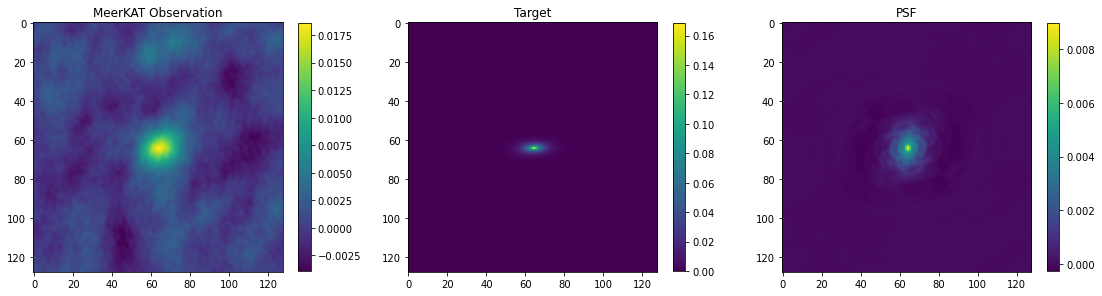

SNR (in Direct Space) = 12.90302512407445
Noise Std (in Direct Space) = 0.0014394049930851905
PSF Flux =  1.0000002



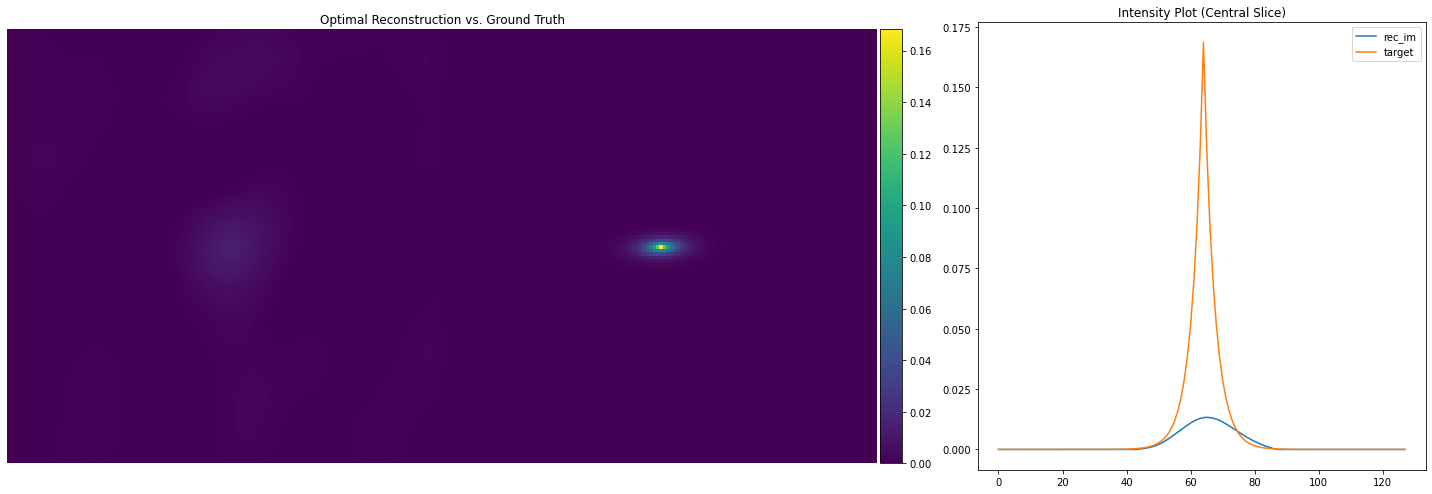

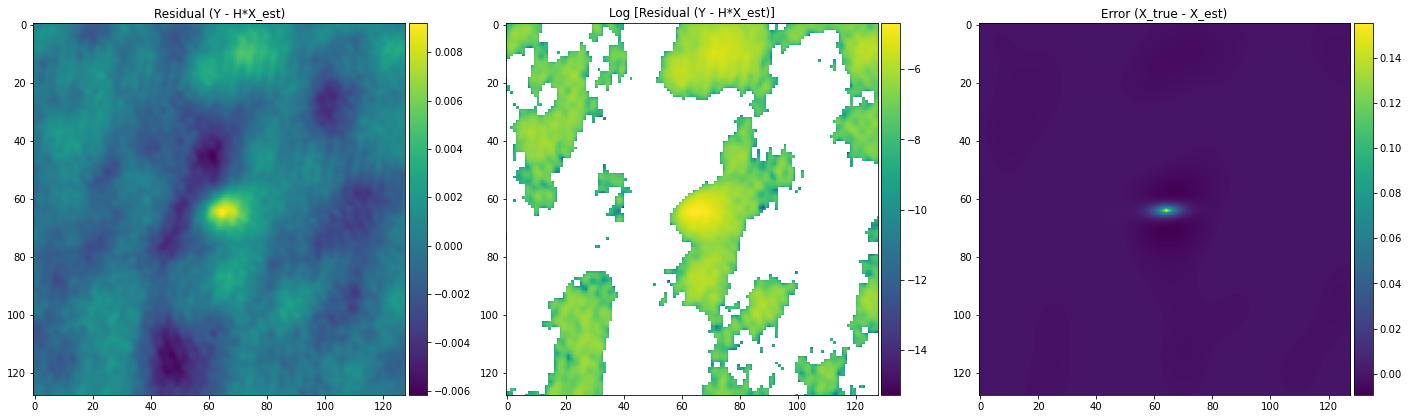

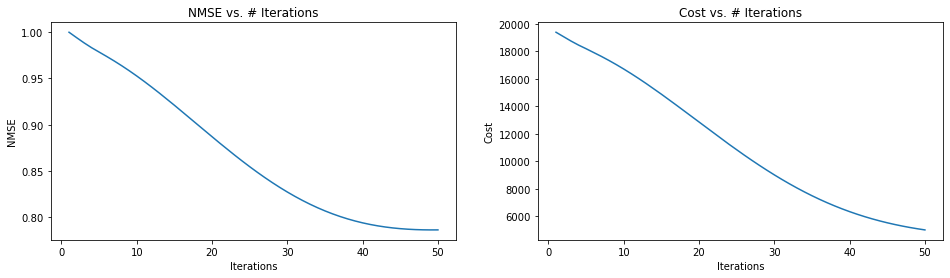


Minimum NMSE = 0.7862707376480103 (at [49] iterations)
Minimum Cost = 5013.47216796875 (at [50] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1420



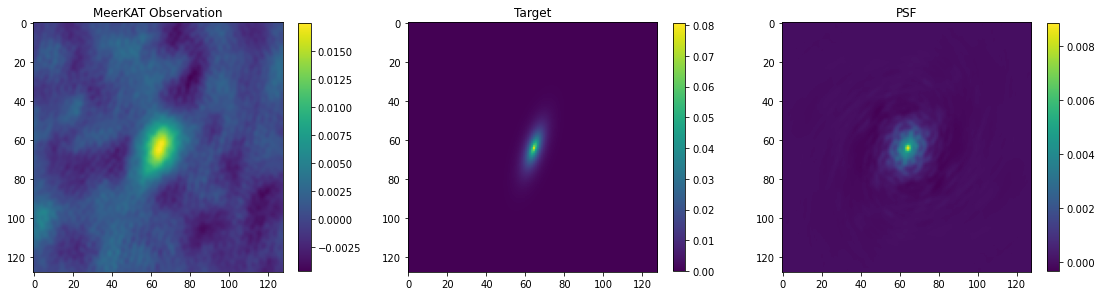

SNR (in Direct Space) = 10.606502560242326
Noise Std (in Direct Space) = 0.0016490400158800183
PSF Flux =  1.0000002



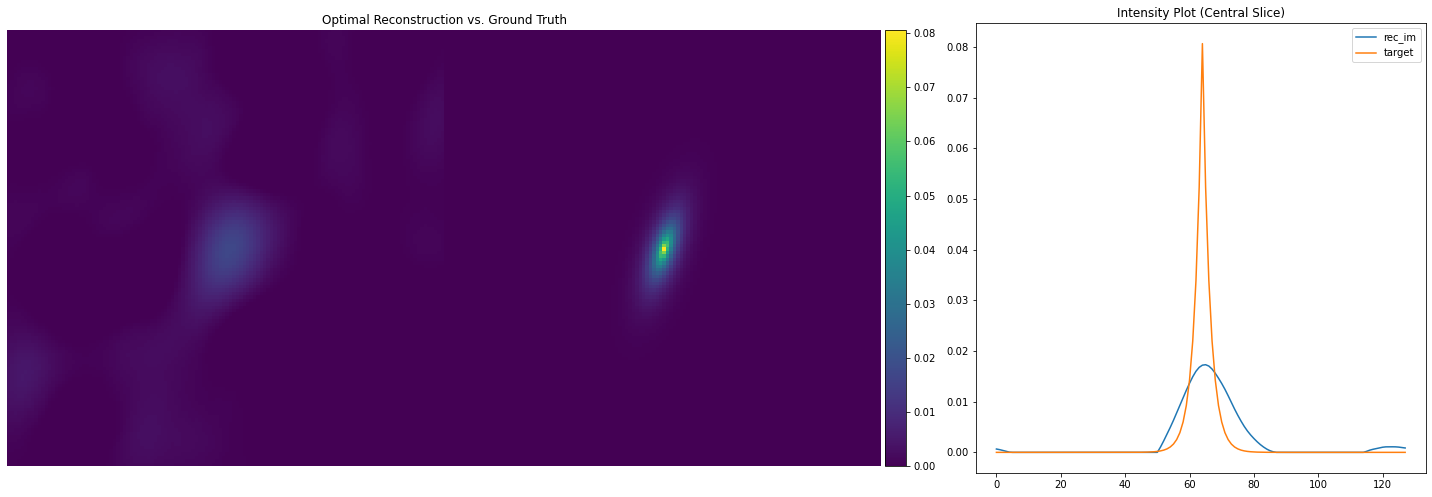

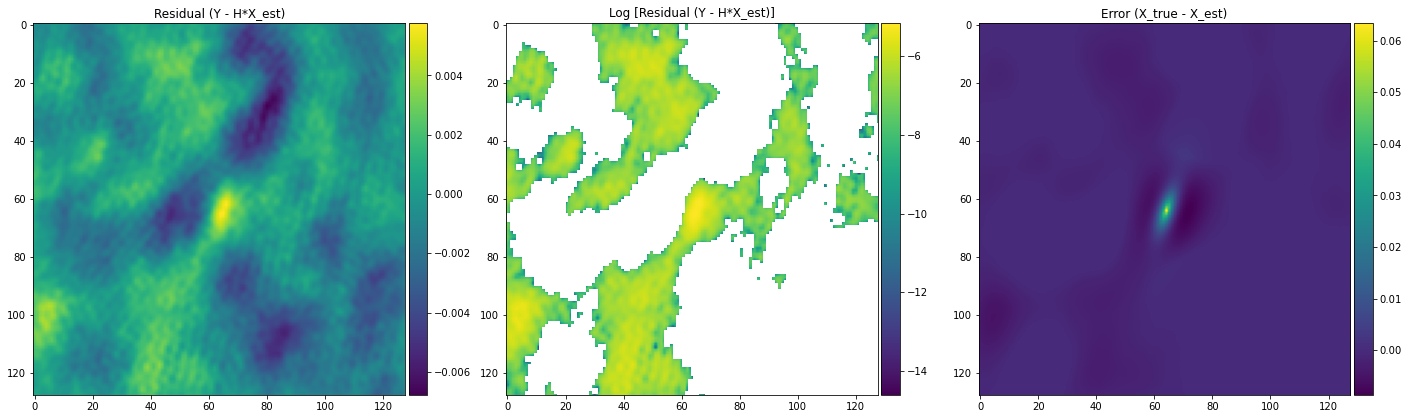

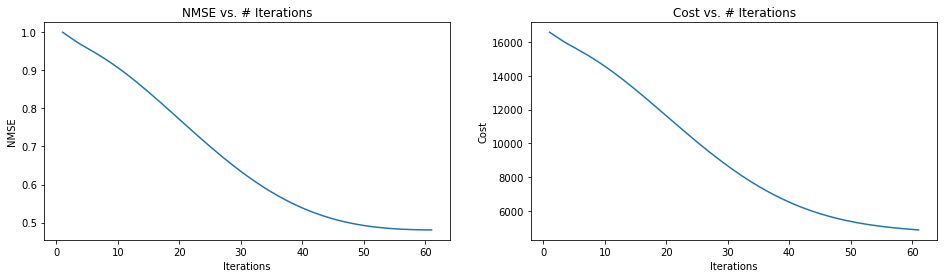


Minimum NMSE = 0.4808320105075836 (at [61] iterations)
Minimum Cost = 4871.97314453125 (at [61] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1410



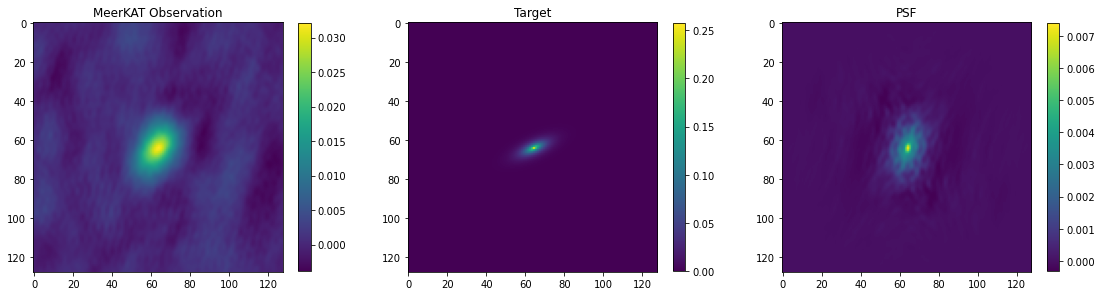

SNR (in Direct Space) = 22.111580906322608
Noise Std (in Direct Space) = 0.0014514667867217212
PSF Flux =  0.9999998



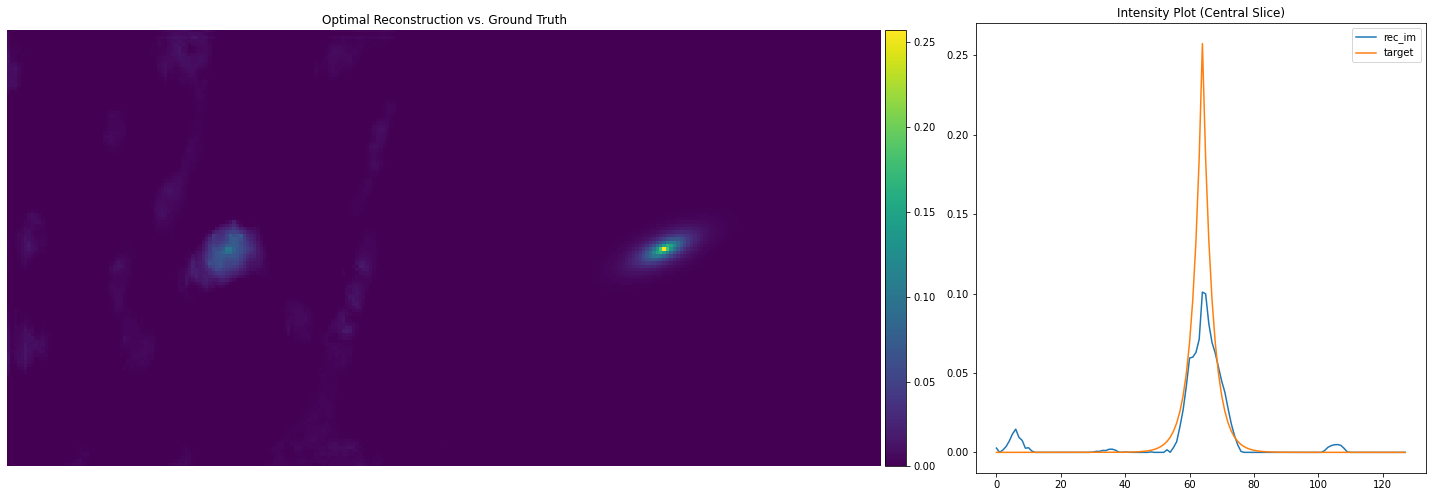

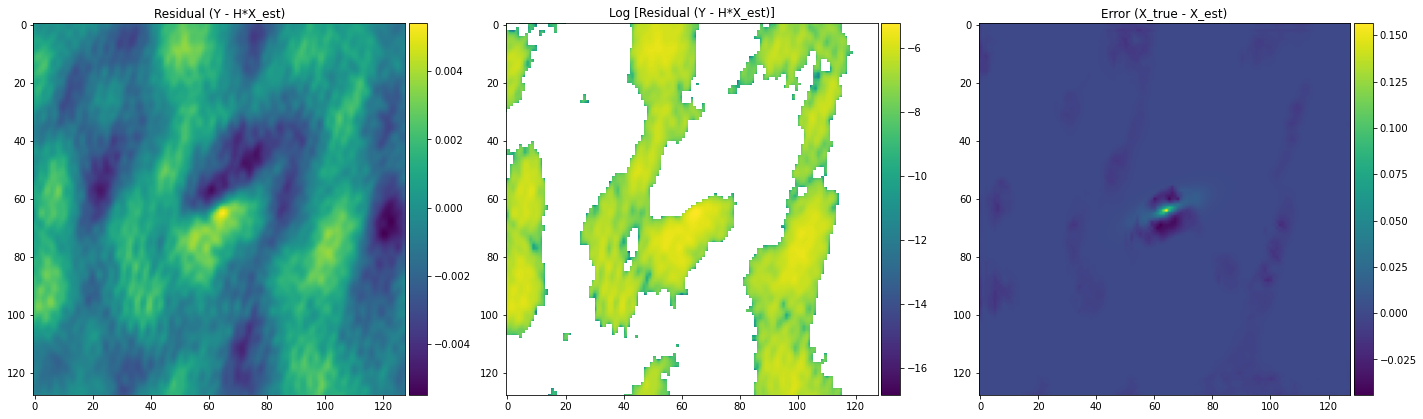

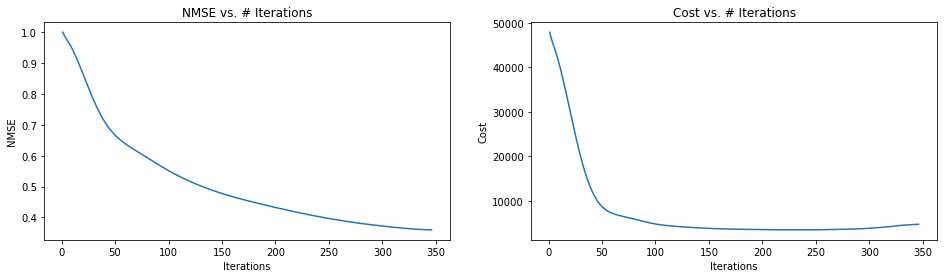


Minimum NMSE = 0.35963496565818787 (at [346] iterations)
Minimum Cost = 3425.825439453125 (at [236] iterations)

_______________________________________________________________________________________________________




In [7]:
n_iter = 500


# ADMM parameters (initial)
x_0 = np.zeros(batch['inputs'][0].shape)
z_0 = np.zeros(batch['inputs'][0].shape)
mu_0 = 0.0                              
rho_0 = 50.0                     # Augmented lagrangian hyperparameter
rho_max = 200.0                  # max rho value
eta = 0.5                        # should be between - [0, 1)
gamma = 1.4                      # multiplicative rho factor -- Should be > 1

x_opt = np.zeros((200, batch['inputs'].shape[1], batch['inputs'].shape[2]))                                 
nmse_arr = np.zeros((200, n_iter))          
cost = np.zeros((200, n_iter)) 


# Deconvolve given images
for gal_ind in range(1600, 1400, -1):
        
    gal_input = tf.cast(np.squeeze(batch['inputs'][gal_ind]), tf.float32)
    gal_target = np.squeeze(batch['targets'][gal_ind])
    psf = tf.cast(np.squeeze(batch['psf'][gal_ind]) , tf.float32)       
    sigma_noise = sigma_mad(gal_input)    
    SNR_D = np.max(gal_input) / sigma_noise         # SNR in direct space

    if gal_ind%10 == 0:
        
        print('\n\n Galaxy Index = {}'.format(gal_ind))
        
        # Plot input, target & psf 
        plot_utils.plot_gal_psf_radio(gal_input, gal_target, psf, sigma_noise, SNR_D)

    # Deconvolve the image
    x_opt[1600-gal_ind], cost[1600-gal_ind], nmse_arr[1600-gal_ind] = runADMM(gal_input, x_0, psf, grad, z_0, 
                                                                              mu_0, rho_0, rho_max, eta, gamma, 
                                                                              sigma_noise, n_iter, model_1)
    if gal_ind%10 == 0:
        
        # Visual Comparison
        plot_utils.comparison(x_opt[1600-gal_ind], gal_target, gal_input, psf, fftconvolve)

        # Plot NMSE & Cost
        plot_utils.nmse_cost(nmse_arr[1600-gal_ind], cost[1600-gal_ind], n_iter)

### Save Output

In [8]:
ADMM_output_meerkat = {}
ADMM_output_meerkat['x_opt'] = x_opt
ADMM_output_meerkat['nmse'] = nmse_arr
ADMM_output_meerkat = dict(chain.from_iterable(d.items() for d in (ADMM_output_meerkat, batch)))

In [9]:
# Save ADMM Output
f = open(data_path + "ADMM_output_meerkat.pkl", "wb")
pickle.dump(ADMM_output_meerkat, f)
f.close()